#  Automated Scoring Algorithm for Student-Written Essays

## Problem Statement

We are attempting to build an automated algorithm for predicting essay scores for student written essays. 

In [0]:
#mount google drive in order to upload data
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#import train data 
import pandas as pd
essay_data = pd.read_csv('/content/drive/Team Drives/ML Project Drive/Data/training_set_rel3.tsv',sep='\t', encoding = 'latin-1', )
essay_data.head(3)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Understanding Our Dataset
Our dataset is from kaggle and includes a pre-estabilish train, validation, and test data which include essays from eight separate essay prompts to enhance the generalizability of our model. The different essay sets may have a varied amount of graders across multiple domains but the overall score is captured in domain_1 score. In addition, essay set 2 has an additional score in domain_2 

For now, let's take a look at the variability in scores by data set


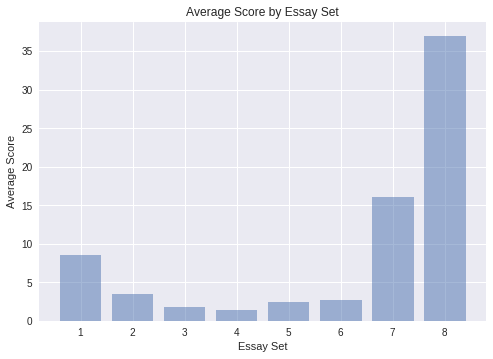

In [0]:
import numpy as np
import matplotlib.pyplot as plt
 
scores = essay_data.groupby('essay_set', as_index=False)['domain1_score'].mean()
y_pos = np.arange(len(scores['essay_set']))
 
plt.bar(y_pos, scores['domain1_score'], align='center', alpha=0.5)
plt.xticks(y_pos, scores['essay_set'].values)
plt.xlabel('Essay Set')
plt.ylabel('Average Score')
plt.title('Average Score by Essay Set')
 
plt.show()

We can see the average scores are extremely varied across the different essay sets. We need to normalize the values based on the different perfect scores on the rubrics for each essay:


*   Essay #1: 12
*   Essay #2: .5x4 + .5x6 = 5 
Note: Essay 2 is reviewed based on two criteria so we need to take the average these two scores
*   Essay #3: 3
*   Essay #4: 3
*   Essay #5: 4
*   Essay #6: 4
*   Essay #7: 30
*   Essay #8: 60









In [0]:
max_scores = [12,1,3,3,4,4,30,60]
scores_norm = scores

#Adding normalized score for the essay sets
scores_norm['score_tot'] = np.divide(scores['domain1_score'],max_scores)

# We need to take into account the second domain score for essay set 2
scores_norm.score_tot[1] = (.5*essay_data.loc[essay_data['essay_set'] == 2]['domain1_score']/6+.5*essay_data.loc[essay_data['essay_set'] == 2]['domain2_score']/4).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


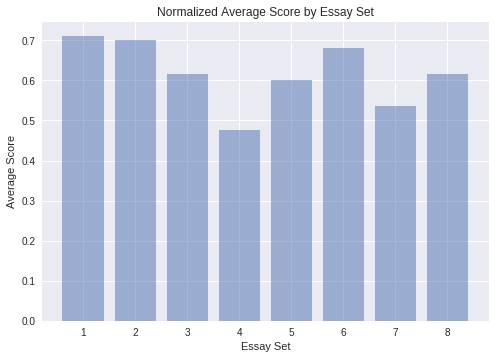

In [0]:
plt.bar(y_pos, scores_norm['score_tot'], align='center', alpha=0.5)
plt.xticks(y_pos, scores_norm['essay_set'].values)
plt.xlabel('Essay Set')
plt.ylabel('Average Score')
plt.title('Normalized Average Score by Essay Set')
 
plt.show()

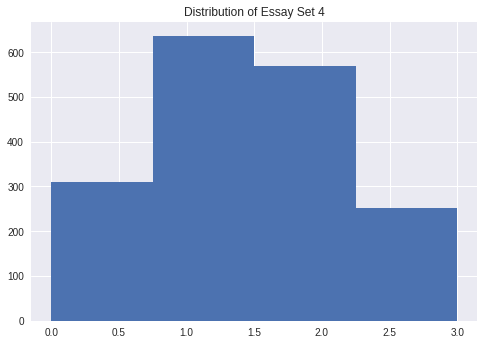

In [0]:
scores_4 = essay_data.loc[essay_data['essay_set']==4]['domain1_score']
 
plt.hist(scores_4, bins = 4)
plt.title('Distribution of Essay Set 4')
 
plt.show()

I've taken a closer look at Essay set 4 because it shows the lowest average score. It seems the distribution is still pretty normal but the low average could be a result of the maximum score being just 3. 

We can see that the data is a little more comparable when we view the scores as a percentage of the total score. We will now convert each data point to a percentage of total score .

Note: We are not acknowledging the various graders' scores at this point but only taking the cumulative score into consideration. For essay set two this is the average of the two domain scores and for every other essay set this is just domain1_score


In [0]:
scores_norm = essay_data[['essay_id','essay_set','essay','domain1_score','domain2_score']]
rubric = {1:12,2:1,3:3,4:3,5:4,6:4,7:30,8:60}
scores_tot = pd.DataFrame()

for i in range(len(essay_data['essay_set'])) :
  scores_tot.loc[i,0] = essay_data.domain1_score[i]/rubric[essay_data.essay_set[i]]

scores_norm['scores_tot'] = scores_tot
scores_norm.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,essay_id,essay_set,essay,domain1_score,domain2_score,scores_tot
0,1,1,"Dear local newspaper, I think effects computer...",8,NaN,0.666667
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,NaN,0.750000
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,NaN,0.583333
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,NaN,0.833333
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,NaN,0.666667


In [0]:
# We have now normalized the scores for all essay sets except for essay set 2 because we need to take into account the second domain score
scores_norm.scores_tot.loc[1783:3582] = (.5*essay_data.loc[essay_data['essay_set'] == 2]['domain1_score']/6+.5*essay_data.loc[essay_data['essay_set'] == 2]['domain2_score']/4)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fadff6f1668>,
      dtype=object)

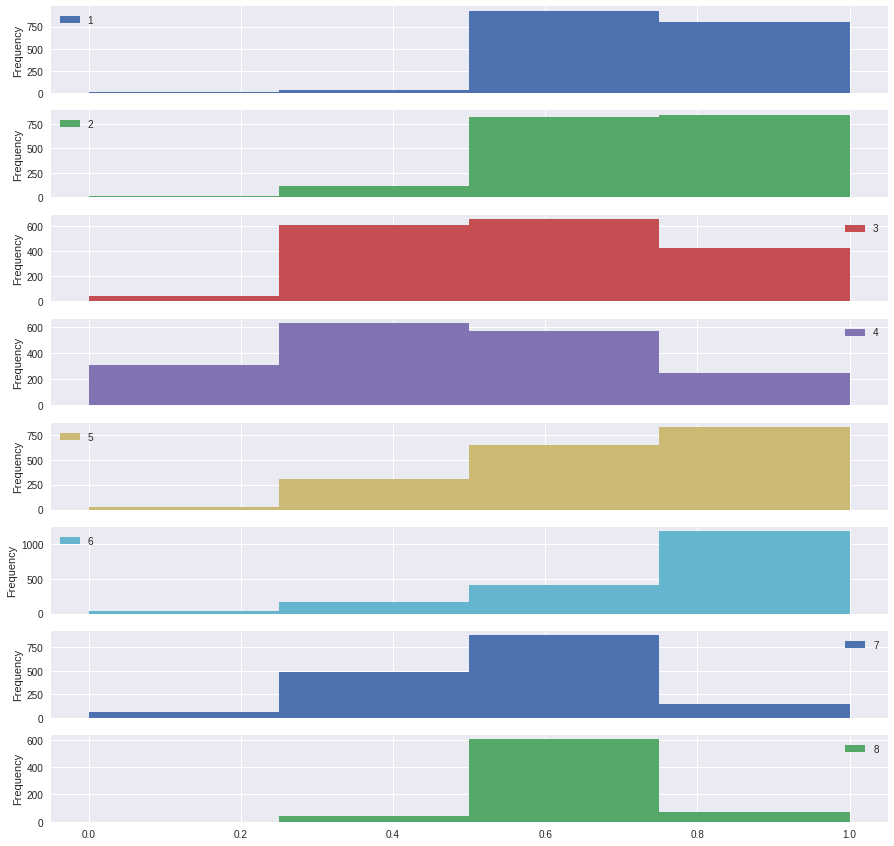

In [0]:
scores_norm.pivot(columns='essay_set', values='scores_tot').plot(kind='hist',bins=4, subplots=True, figsize= (15,15))

## Creating Sample Features

Now we will derive the features from our essay data to create the feature set for our base model

In [0]:
# We will start with the data that has been cleaned and run through sentiment analysis by Cullen 
import pickle
base_feat = pickle.load( open( '/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 1 - Data Preprocessing/scores_norm_1.obj', "rb" ) ) 
base_feat.head(3)

,essay_id,essay_set,essay,domain1_score,domain2_score,essay_clean,spellCheckedEssay,spellingErrorCount,polarity,subjectivity
0,1,1,"Dear local newspaper, I think effects computer...",8.0,NaN,dear local newspaper i think effects computers...,dear local newspaper i think effects computers...,11,0.278120,0.393272
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,NaN,dear i believe that using computers will benef...,dear i believe that using computers will benef...,16,0.274000,0.613167
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,NaN,dear more and more people use computers but no...,dear more and more people use computers but no...,2,0.340393,0.498657


Now we are going to add features to the data based on the documentation:

Average Essay Length: av_len
Grade Level: grade
Essay type: essay_type

1: Persuasive/ Narrative/Expository; 2: Source Dependent Responses

In [0]:
import pandas as pd

# Add normalized scores to base feature set
rubric = {1:12,2:1,3:3,4:3,5:4,6:4,7:30,8:60}
scores_tot = pd.DataFrame()

for i in range(len(base_feat.essay_id)) :
  scores_tot.loc[i,0] = base_feat.domain1_score[i]/rubric[base_feat.essay_set[i]]

base_feat['scores_norm'] = scores_tot
# We have now normalized the scores for all essay sets except for essay set 2 because we need to take into account the second domain score
base_feat.scores_norm.loc[1783:3582] = (base_feat.loc[base_feat['essay_set'] == 2]['domain1_score']+base_feat.loc[base_feat['essay_set'] == 2]['domain2_score'])/10

# Add features from the rubric
av_len = {1:350,2:350,3:150,4:150,5:150,6:150,7:250,8:650}
grade = {1:8,2:10,3:10,4:10,5:8,6:10,7:7,8:10}
essay_type = {1:1,2:1,3:2,4:2,5:2,6:2,7:1,8:1}
features = pd.DataFrame(columns=['av_length', 'grade', 'essay_type'])
for i in range(len(base_feat['essay_set'])):
  features.loc[i] = [av_len[base_feat.essay_set[i]],grade[base_feat.essay_set[i]],essay_type[base_feat.essay_set[i]]] 


# Add essay features to the scores norm
base_feat['av_len'] = features['av_length']
base_feat['grade'] = features['grade']
# Hot encoding essay type
base_feat['essay_type_1']= 2-features['essay_type'].values
base_feat['essay_type_2']= features['essay_type'].values-1
                     
# Add column for Total word count divided by the average word count of the essay set (len_per)
length_tot = pd.Series(len(base_feat['essay']))
length_per = pd.Series(len(base_feat['essay']))

for i in range(len(base_feat['essay'])) :
  length_tot[i] = len(base_feat.essay[i].split())
  length_per[i] = (length_tot[i]-base_feat.av_len[i])/base_feat.av_len[i]

base_feat['len_tot'] = length_tot
base_feat['len_per'] = length_per

base_feat.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,essay_id,essay_set,essay,domain1_score,domain2_score,essay_clean,spellCheckedEssay,spellingErrorCount,polarity,subjectivity,scores_norm,av_len,grade,essay_type_1,essay_type_2,len_tot,len_per
0,1,1,"Dear local newspaper, I think effects computer...",8.0,NaN,dear local newspaper i think effects computers...,dear local newspaper i think effects computers...,11,0.278120,0.393272,0.666667,350,8,1,0,338,0.000000
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,NaN,dear i believe that using computers will benef...,dear i believe that using computers will benef...,16,0.274000,0.613167,0.750000,350,8,1,0,419,0.197143
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,NaN,dear more and more people use computers but no...,dear more and more people use computers but no...,2,0.340393,0.498657,0.583333,350,8,1,0,279,-0.202857


Now we will add in Dan's features to the feature set


In [0]:
import pandas as pd
import nltk
import string
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from collections import Counter
from nltk.corpus import stopwords
import collections

#E - Average words per sentance

def mean_sentance_len(mylist, myset):
  cnt = 0
  avg = 0
  
  for word in mylist:
    for c in myset:
      if c in word: cnt += 1
        
  return cnt      
    
terminals = set([".","!","?"]) # sets are efficient for "membership" tests
avg_sent_len = pd.Series(len(base_feat['spellCheckedEssay']))  

for i in range(len(base_feat['spellCheckedEssay'])): # Loop through all essays
  avg_sent_len[i] = mean_sentance_len(base_feat.essay[i].split(), terminals) # split essay
  
base_feat['avg_sent_len'] = avg_sent_len

#F - Parts of Speech Count

def parts_of_speech(essay):

  tokens = nltk.word_tokenize(essay)
  tokens = nltk.pos_tag(tokens)

  counts = Counter(tag for word,tag in tokens)

  adj_count = 0
  noun_count = 0
  pronoun_count = 0
  adv_count = 0
  verb_count = 0


  ## Aggregate JJ(simple), JJR(comparative), and JJS(superlative) into single adjective category

  adj = counts.get('JJ')
  if adj is None:
    adj = 0

  adj0 = counts.get('JJR')
  if adj0 is None:
    adj0 = 0

  adj1 = counts.get('JJS')
  if adj1 is None:
    adj1 = 0  


  ## Aggregate NN(singluar), NNS(plural), NNP(proper), and NNPS(plural proper) into single noun category

  noun = counts.get('NN')
  if noun is None:
    noun = 0

  noun0 = counts.get('NNS')
  if noun0 is None:
    noun0 = 0

  noun1 = counts.get('NNP')
  if noun1 is None:
    noun1 = 0  

  noun2 = counts.get('NNPS')
  if noun2 is None:
    noun2 = 0


  ## Aggregate PRP(personal), PRP$(personal-possesive), WP(Who/what), and WP$(whose) into single pronoun category

  pro = counts.get('PRP')
  if pro is None:
    pro = 0

  pro0 = counts.get('PRP$')
  if pro0 is None:
    pro0 = 0

  pro1 = counts.get('WP')
  if pro1 is None:
    pro1 = 0  

  pro2 = counts.get('WP$')
  if pro2 is None:
    pro2 = 0


  ## Aggregate RB(simple), RBR(comparative), and RBS(superlative) into single adverb category

  adv = counts.get('RB')
  if adv is None:
    adv = 0

  adv0 = counts.get('RBR')
  if adv0 is None:
    adv0 = 0

  adv1 = counts.get('RBS')
  if adv1 is None:
    adv1 = 0  


  ## Aggregate VB(base), VBD(past), VBG(present participle), VBN(past participle), VBP(sing. present), and VBZ(3rd-person present)  into single verb category

  verb = counts.get('VB')
  if verb is None:
    verb = 0

  verb0 = counts.get('VBD')
  if verb0 is None:
    verb0 = 0

  verb1 = counts.get('VBG')
  if verb1 is None:
    verb1 = 0  

  verb2 = counts.get('VBN')
  if verb2 is None:
    verb2 = 0

  verb3 = counts.get('VBP')
  if verb3 is None:
    verb3 = 0

  verb4 = counts.get('VBZ')
  if verb4 is None:
    verb4 = 0  

  adj_count = adj + adj0 + adj1
  noun_count = noun + noun0 + noun1 + noun2
  pronoun_count = pro + pro0 + pro1 + pro2
  adv_count = adv + adv0 + adv1
  verb_count = verb + verb0 + verb1 + verb2 + verb3 +verb4
  
  return(noun_count, pronoun_count, adj_count, verb_count, adv_count)


noun_cnt = pd.Series(len(base_feat['spellCheckedEssay']))  
pnoun_cnt = pd.Series(len(base_feat['spellCheckedEssay']))
verb_cnt = pd.Series(len(base_feat['spellCheckedEssay']))
averb_cnt = pd.Series(len(base_feat['spellCheckedEssay']))
adj_cnt = pd.Series(len(base_feat['spellCheckedEssay']))

for i in range(len(base_feat['spellCheckedEssay'])): # Loop through all essays
  noun_cnt[i], pnoun_cnt[i], verb_cnt[i], averb_cnt[i], adj_cnt[i] = parts_of_speech(base_feat.essay[i])
  
base_feat['noun_count'] = noun_cnt
base_feat['pronoun_count'] = pnoun_cnt
base_feat['verb_count'] = verb_cnt
base_feat['adverb_count'] = averb_cnt
base_feat['adjective_count'] = adj_cnt

# I - Lemma Count


def preprocess(sentence):
	sentence = sentence.lower()
	tokenizer = RegexpTokenizer(r'\w+')
	tokens = tokenizer.tokenize(sentence)
	filtered_words = [w for w in tokens if not w in stopwords.words('english')]
	return " ".join(filtered_words)

def remove_duplicates(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list


def unique_lemma_count(essay):
  
  wordnet_lemmatizer = WordNetLemmatizer()
  
  tokens = nltk.word_tokenize(preprocess(essay))
  tokens = nltk.pos_tag(tokens)
  lemmas =[]
  
  
  for token_tuple in tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))

  lemmas = remove_duplicates(lemmas)
  return len(lemmas)

lemma_cnt = pd.Series(len(base_feat['spellCheckedEssay']))

for i in range(len(base_feat['spellCheckedEssay'])): # Loop through all essays
  lemma_cnt[i] = unique_lemma_count(base_feat.essay[i])

base_feat['lemma_count'] = lemma_cnt

## Average Word Length

def average_word_length(essay):
  char_count = len(''.join(i for i in essay if i.isalnum()))
  word_count = len(essay.split(" "))
  return char_count/word_count


avg_word_len = pd.Series(len(base_feat['spellCheckedEssay']))

for i in range(len(base_feat['spellCheckedEssay'])): # Loop through all essays
  avg_word_len[i] = average_word_length(base_feat.essay[i])
  
base_feat['avg_word_len'] = avg_word_len

base_feat.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,essay_id,essay_set,essay,domain1_score,domain2_score,essay_clean,spellCheckedEssay,spellingErrorCount,polarity,subjectivity,...,len_tot,len_per,avg_sent_len,noun_count,pronoun_count,verb_count,adverb_count,adjective_count,lemma_count,avg_word_len
0,1,1,"Dear local newspaper, I think effects computer...",8.0,NaN,dear local newspaper i think effects computers...,dear local newspaper i think effects computers...,11,0.278120,0.393272,...,338,0.000000,16,84,42,22,68,21,104,4.000000
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,NaN,dear i believe that using computers will benef...,dear i believe that using computers will benef...,16,0.274000,0.613167,...,419,0.197143,20,114,42,21,85,18,124,4.353222
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,NaN,dear more and more people use computers but no...,dear more and more people use computers but no...,2,0.340393,0.498657,...,279,-0.202857,14,86,21,19,53,14,85,4.405018
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,NaN,dear local newspaper i have found that many ex...,dear local newspaper i have found that many ex...,24,0.230281,0.470421,...,524,0.497143,27,197,26,52,100,28,175,4.868321
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,NaN,dear i know having computers has a positive ef...,dear i know having computers has a positive ef...,13,0.194564,0.474639,...,465,0.328571,30,116,29,32,87,36,121,4.408602


In [0]:
#
import pandas as pd
countFields = ['spellingErrorCount', 'noun_count', 'pronoun_count', 'verb_count', 'adverb_count', 'adjective_count', 'lemma_count']
countsToRates = base_feat[countFields].div(base_feat['len_tot'], axis=0)
countsToRates.columns = ['spellingErrorRate', 'noun_rate', 'pronoun_rate', 'verb_rate', 'adverb_rate', 'adjective_rate', 'lemma_rate']

base_feat_trans = base_feat.drop(countFields, axis=1)
base_feat_trans = pd.concat([base_feat_trans.reset_index(drop=True), countsToRates], axis=1)

In [0]:
# Save base_feat_transformed which contains all features used for the base model including intermediate featurea
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 1 - Data Preprocessing/base_feat_trans', 'wb') as scores_norm_file:
  pickle.dump(base_feat_trans, scores_norm_file)

In [0]:
base_feat_final = base_feat_trans.drop(columns= ['essay_id', 'essay', 'domain1_score','av_len', 'domain2_score',
       'essay_clean', 'spellCheckedEssay','len_tot'])
base_feat_final = base_feat_final.dropna()

In [0]:
# Save base_feat_transformed which contains all features used for the base model including intermediate featurea
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 1 - Data Preprocessing/base_feat_final', 'wb') as scores_norm_file:
  pickle.dump(base_feat_final, scores_norm_file)

In [0]:
base_feat_final.head()

,essay_set,polarity,subjectivity,scores_norm,grade,essay_type_1,essay_type_2,len_per,avg_sent_len,avg_word_len,spellingErrorRate,noun_rate,pronoun_rate,verb_rate,adverb_rate,adjective_rate,lemma_rate
0,1,0.278120,0.393272,0.666667,8,1,0,0.000000,16,4.000000,0.032544,0.248521,0.124260,0.065089,0.201183,0.062130,0.307692
1,1,0.274000,0.613167,0.750000,8,1,0,0.197143,20,4.353222,0.038186,0.272076,0.100239,0.050119,0.202864,0.042959,0.295943
2,1,0.340393,0.498657,0.583333,8,1,0,-0.202857,14,4.405018,0.007168,0.308244,0.075269,0.068100,0.189964,0.050179,0.304659
3,1,0.230281,0.470421,0.833333,8,1,0,0.497143,27,4.868321,0.045802,0.375954,0.049618,0.099237,0.190840,0.053435,0.333969
4,1,0.194564,0.474639,0.666667,8,1,0,0.328571,30,4.408602,0.027957,0.249462,0.062366,0.068817,0.187097,0.077419,0.260215


##Understanding Essay Features

Import Feature Set

In [0]:
import pickle
import pandas as pd
base_feat_final = pd.read_pickle('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 1 - Data Preprocessing/base_feat_final')


Let's take a look at the correlation between all feature and the target variable(scores_norm).

In [0]:
from scipy.stats.stats import pearsonr

features = base_feat_final.columns.tolist()
features.remove('essay_set')
features.remove('scores_norm')
target = base_feat_final.iloc[:,3].name

correlations = {}
for f in features:
    data_temp = base_feat_final[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=["Pearson's R"]).T
data_correlations.loc[data_correlations["Pearson's R"].abs().sort_values(ascending=False).index]

,Pearson's R
len_per vs scores_norm,0.700697
avg_sent_len vs scores_norm,0.381902
avg_word_len vs scores_norm,0.252520
verb_rate vs scores_norm,0.190009
pronoun_rate vs scores_norm,-0.169459
spellingErrorRate vs scores_norm,-0.156546
lemma_rate vs scores_norm,-0.147193
noun_rate vs scores_norm,0.141186
adverb_rate vs scores_norm,-0.133716
subjectivity vs scores_norm,0.109073


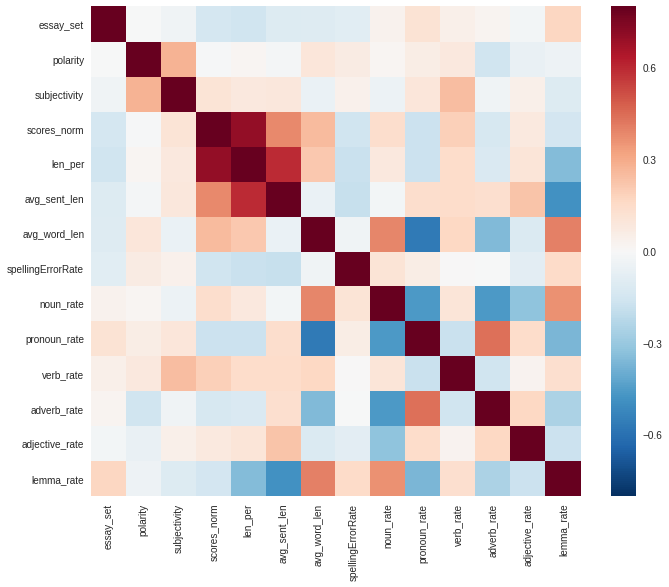

In [0]:
# Heat Map

import seaborn as sns

#correlation matrix
corrmat = base_feat_final.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

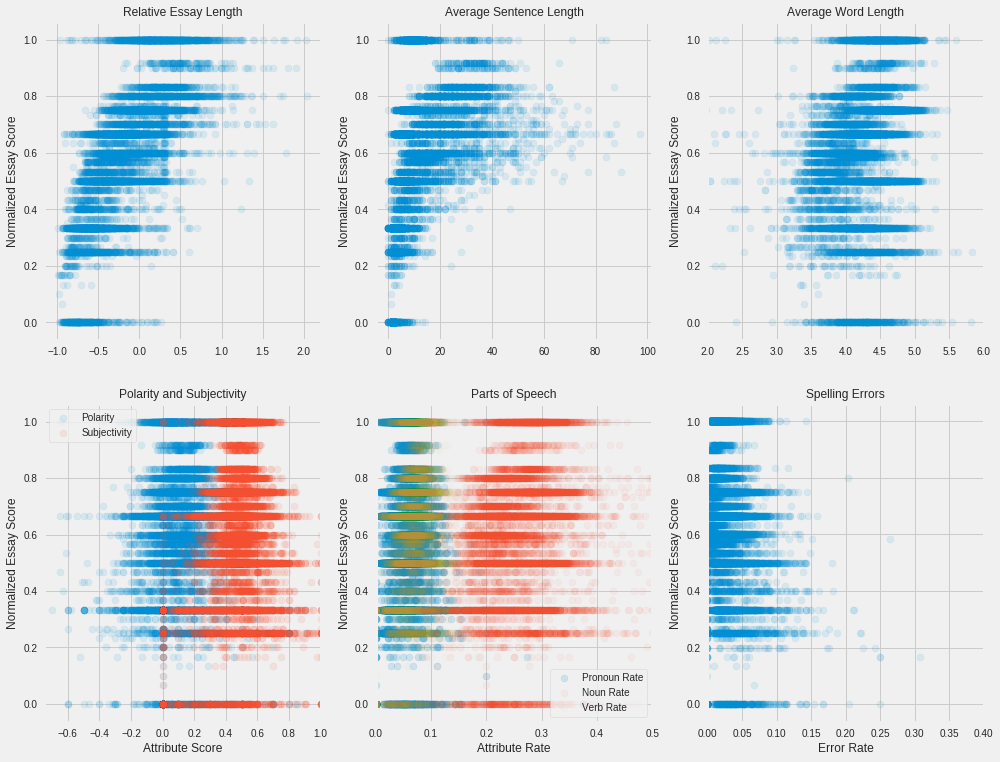

In [0]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,12))

target = base_feat_final['scores_norm']
rate1 = base_feat_final['len_per']
rate2 = base_feat_final['avg_word_len']
rate3 = base_feat_final['avg_sent_len']
rate4 = base_feat_final['polarity']
rate5 = base_feat_final['subjectivity']
rate6 = base_feat_final['pronoun_rate']
rate7 = base_feat_final['noun_rate']
rate8 = base_feat_final['verb_rate']
rate9 = base_feat_final['spellingErrorRate']
rate10 = base_feat_final['adjective_rate']

plt.subplot(2, 3, 1)
plt.scatter(rate1, target, alpha=0.1, label = 'Avg Word Count Percent')
plt.title('Relative Essay Length', fontsize = 12)
plt.ylabel('Normalized Essay Score', fontsize = 12)


plt.subplot(2, 3, 2)
plt.scatter(rate3, target, alpha=0.1, label = 'Average Sentence Length')
plt.title('Average Sentence Length',fontsize = 12)
plt.ylabel('Normalized Essay Score', fontsize = 12)

plt.subplot(2, 3, 3)
plt.scatter(rate2, target, alpha=0.1, label = 'Average Word Length')
plt.xlim(2,6)
plt.title('Average Word Length',fontsize = 12)
plt.ylabel('Normalized Essay Score', fontsize = 12)


plt.subplot(2, 3, 4)
plt.scatter(rate4, target, alpha=0.1, label = 'Polarity')
plt.scatter(rate5, target, alpha=0.1, label = 'Subjectivity' )
plt.legend(loc='upper left', frameon=True)
plt.xlim(-.75,1)
plt.title('Polarity and Subjectivity', fontsize = 12)
plt.ylabel('Normalized Essay Score', fontsize = 12)
plt.xlabel('Attribute Score', fontsize = 12)

plt.subplot(2, 3, 5)
plt.scatter(rate10, target, alpha=0.15, label = 'Pronoun Rate' )
plt.scatter(rate7, target, alpha=0.05, label = 'Noun Rate' )
plt.scatter(rate8, target, alpha=0.02, label = 'Verb Rate' )
plt.legend(loc='lower right', frameon=True)
plt.title('Parts of Speech', fontsize = 12)
plt.xlim(0,0.5)
plt.ylabel('Normalized Essay Score', fontsize = 12)
plt.xlabel('Attribute Rate', fontsize = 12)

plt.subplot(2, 3, 6)
plt.scatter(rate9, target, alpha=0.1, label = 'spellingErrorRate')
plt.title('Spelling Errors', fontsize = 12)
plt.xlim(0,0.4)
plt.ylabel('Normalized Essay Score', fontsize = 12)
plt.xlabel('Error Rate', fontsize = 12)

plt.show()

##Split the base model data into train/test/ and validation dataset

In [0]:
from sklearn.model_selection import train_test_split
# First separate out the test data
X_train, X_test, y_train, y_test = train_test_split(base_feat_final.drop(columns='scores_norm'), base_feat_final['scores_norm'], test_size=0.2, random_state=1)

#Now split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=789)

In [0]:
# Save separated data
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_train', 'wb') as scores_norm_file:
  pickle.dump(X_train, scores_norm_file)
  
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_test', 'wb') as scores_norm_file:
  pickle.dump(X_test, scores_norm_file)

with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_val', 'wb') as scores_norm_file:
  pickle.dump(X_val, scores_norm_file)
  
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_train', 'wb') as scores_norm_file:
  pickle.dump(y_train, scores_norm_file)

with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_test', 'wb') as scores_norm_file:
  pickle.dump(y_test, scores_norm_file)
  
with open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_val', 'wb') as scores_norm_file:
  pickle.dump(y_val, scores_norm_file)

##Creating the Base Model and Testing on Validation Data

In [0]:
# Load in pickle object from above
import pickle
X_train = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_train', "rb" ))
y_train = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_train', "rb" ))
X_val = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_val', "rb" ))
y_val = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_val', "rb" ))

In [0]:
import pandas as pd
y_train_class = pd.cut(y_train, [-0.10, 0.2, 0.4, 0.6, 0.8, 1.1], labels=["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"], 
                       retbins=False, right=False)
#y_train_class = pd.to_numeric(y_train_class.round(0)).astype(int)

y_val_class = pd.cut(y_val, [-0.10, 0.2, 0.4, 0.6, 0.8, 1.1], labels=["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"], 
                     retbins=False, right=False)
#y_val_class = pd.to_numeric(y_val_class.round(0)).astype(int)

Assess single factor fit of each base feature.

## Model Builds

### Base Model - Logistic Regression Singular Value Decomposition with TF-IDF

In [0]:
transformed_base_feat = pickle.load( open( '/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 1 - Data Preprocessing/base_feat_trans', "rb" ) )

# Add essay data back into X_train data set
import pandas as pd
X_train_essay = pd.DataFrame(columns=['Essay'], index = y_train.index.values)
for i in y_train.index:
  X_train_essay.loc[i] = transformed_base_feat.spellCheckedEssay.loc[i]
  
X_train['Essay'] = X_train_essay

X_val_essay = pd.DataFrame(columns=['Essay'], index = y_val.index.values)
for i in y_val.index:
  X_val_essay.loc[i] = transformed_base_feat.spellCheckedEssay.loc[i]
  
X_val['Essay'] = X_val_essay


In [0]:
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer

count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(X_train['Essay'])
tfidf_val = count_vectorizer.fit(X_train['Essay']).transform(X_val['Essay'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)
truncated_tfidf_val = svd.fit_transform(tfidf_val)

In [0]:
!pip install scikit-plot
import scikitplot.plotters as skplt
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

base_model = LogisticRegression().fit(tfidf, y_train_class) 
base_model_pred = base_model.predict(tfidf)
base_model_pred_val = base_model.predict(tfidf_val)

Accuracy: 0.7033959537572254


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


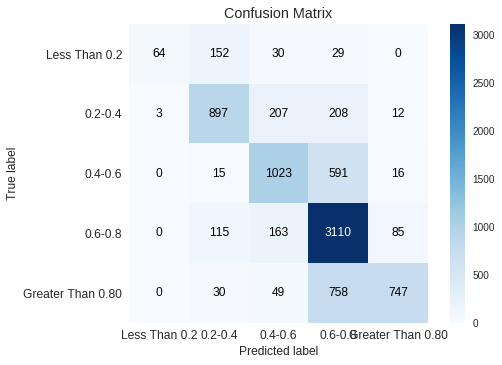

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_train_class, base_model_pred)))

skplt.plot_confusion_matrix(y_train_class, base_model_pred,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

Accuracy: 0.5512758786711603


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


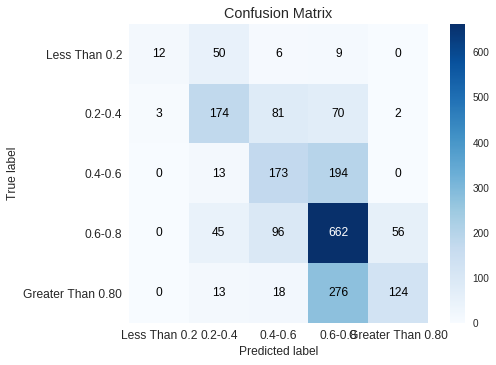

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_val_class, base_model_pred_val)))

skplt.plot_confusion_matrix(y_val_class, base_model_pred_val,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

In [0]:
base_model2 = LogisticRegression().fit(truncated_tfidf, y_train_class) 
base_model_pred2 = base_model2.predict(truncated_tfidf)
base_model_pred_val2 = base_model2.predict(truncated_tfidf_val)

Accuracy: 0.5096339113680154


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


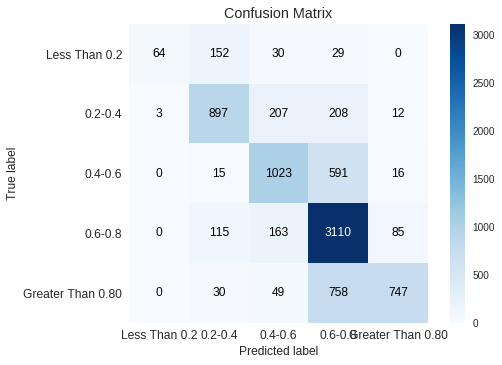

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_train_class, base_model_pred2)))

skplt.plot_confusion_matrix(y_train_class, base_model_pred,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

Accuracy: 0.39768897448242657


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


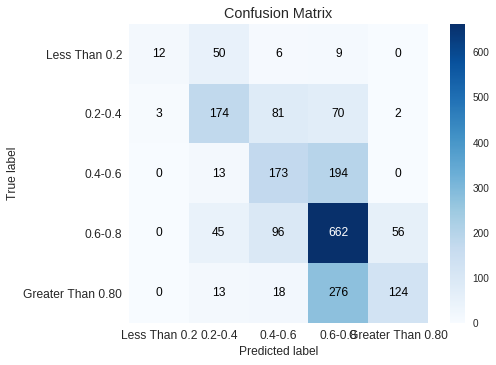

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_val_class, base_model_pred_val2)))

skplt.plot_confusion_matrix(y_val_class, base_model_pred_val,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

In [0]:
X_train = X_train.drop(columns = 'Essay')
X_val = X_val.drop(columns = 'Essay')

ValueError: ignored

### Model 1: XGBoost with CV GridSearch

#### Scale the Feature Space

First let's scale the feature space with StandardScaler.

In [0]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train,y = None) # fit and transform x_train
X_val_s = scaler.transform(X_val) # transform x_test
print(np.mean(X_train_s)) # verify mean = 0
print(np.std(X_train_s)) # verify deviation = 1
print(np.mean(X_val_s)) # verify mean is close to 0
print(np.std(X_val_s)) # verify deviation is close to 1

-2.631164393620313e-17
1.0
0.005533547220732114
1.0091337575177721


#### Base XGBoost

In [0]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [0]:
xg_base = xgb.XGBClassifier()

XGBase = xg_base.fit(X_train_s,y_train_class,verbose = False)

In [0]:
print("XGBoost Trainig Accuracy Score:")
print(xg_base.score(X_train_s,y_train_class))
print("XGBoost Validation Accuracy Score:")
print(xg_base.score(X_val_s,y_val_class))

XGBoost Trainig Accuracy Score:
0.6921965317919075
XGBoost Validation Accuracy Score:
0.6668271545498314


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


####XGBoost with Cross Validation Grid Search

In [0]:
xg_reg = xgb.XGBClassifier()

params = { 
        'gamma': [0,0.5,1] # set gamma
        'max_depth': [3,4,5], # set depth
        'n_estimators':[50, 100, 250, 500], # set estimator count
        'reg_alpha': [0,.5,1], # set L1 regularization
        'reg_lambda':[1,1.5,2] # set L2 regularization
        }

xg_grid = GridSearchCV(xg_reg, params)
XGrid = xg_grid.fit(X_train_s,y_train_class, verbose = False)
print(xg_grid.best_estimator_)


In [0]:
print("XGBoost Trainig Accuracy Score:")
print(xg_grid.score(X_train_s,y_train_class))
print("XGBoost Validation Accuracy Score:")
print(xg_grid.score(X_val_s,y_val_class))
print(xg_grid.best_estimator_)

XGBoost Trainig Accuracy Score:
0.7255539499036608
XGBoost Validation Accuracy Score:
0.6644198363023591
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1, reg_lambda=1.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### XGBoost with CVGridSearch + Early Stopping

In [0]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'gamma': [0,0.5,1], # set gamma
              "max_depth": [3, 4, 5], # set max depth range
              'n_estimators':[100, 250, 500, 1000], # set estimator count
              'reg_alpha': [0,.5,1], # set L1 regularization
              'reg_lambda':[1,1.5,2] # set L2 regularization
             }

fit_dict = {"eval_set":[(X_val_s, y_val_class)],
          "early_stopping_rounds":5,
          "eval_metric":"merror"}
alg = xgb.XGBClassifier(n_estimators=100)
clf = RandomizedSearchCV(estimator = alg,
                     param_distributions = param_dist,
                     n_iter = 20,
                     fit_params = fit_dict)

clf.fit(X_train_s,y_train_class)

[0]	validation_0-merror:0.356283
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913
[2]	validation_0-merror:0.354357


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:585: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[3]	validation_0-merror:0.352913
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.354839
[6]	validation_0-merror:0.356283
Stopping. Best iteration:
[1]	validation_0-merror:0.352913

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362542


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.363505
[3]	validation_0-merror:0.358209
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.354357
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.351468
[8]	validation_0-merror:0.353394
[9]	validation_0-merror:0.351468
[10]	validation_0-merror:0.349543
[11]	validation_0-merror:0.349543
[12]	validation_0-merror:0.347617
[13]	validation_0-merror:0.347135
[14]	validation_0-merror:0.346654
[15]	validation_0-merror:0.349061
[16]	validation_0-merror:0.343284
[17]	validation_0-merror:0.345691
[18]	validation_0-merror:0.340876
[19]	validation_0-merror:0.337987
[20]	validation_0-merror:0.338469
[21]	validation_0-merror:0.339913
[22]	validation_0-merror:0.340395
[23]	validation_0-merror:0.33895
[24]	validation_0-merror:0.337506
[25]	validation_0-merror:0.337025
[26]	validation_0-merror:0.336062
[27]	validation_0-merror:0.33221
[28]	validation_0-merror:0.334617
[29]	validation_0-merror:0.335099
[30]	validation_0-merror:0.332691
[31]	validation_0-merror

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.362061
[3]	validation_0-merror:0.355802
[4]	validation_0-merror:0.348098
[5]	validation_0-merror:0.35195
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.350024
[8]	validation_0-merror:0.350024
[9]	validation_0-merror:0.349061
Stopping. Best iteration:
[4]	validation_0-merror:0.348098

[0]	validation_0-merror:0.376505
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376505
[2]	validation_0-merror:0.377468


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.376023
[5]	validation_0-merror:0.376023
[6]	validation_0-merror:0.374097
[7]	validation_0-merror:0.374097
[8]	validation_0-merror:0.372171
[9]	validation_0-merror:0.372171
[10]	validation_0-merror:0.37169
[11]	validation_0-merror:0.372653
[12]	validation_0-merror:0.372653
[13]	validation_0-merror:0.367357
[14]	validation_0-merror:0.367838
[15]	validation_0-merror:0.364468
[16]	validation_0-merror:0.356765
[17]	validation_0-merror:0.359653
[18]	validation_0-merror:0.361098
[19]	validation_0-merror:0.358209
[20]	validation_0-merror:0.360616
[21]	validation_0-merror:0.360135
Stopping. Best iteration:
[16]	validation_0-merror:0.356765

[0]	validation_0-merror:0.382764
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381801


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.382282
[3]	validation_0-merror:0.381801
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.382764
[6]	validation_0-merror:0.383727
Stopping. Best iteration:
[1]	validation_0-merror:0.381801

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.377949
[4]	validation_0-merror:0.376986
[5]	validation_0-merror:0.376023
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.376505
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376505
[2]	validation_0-merror:0.377468


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.376023
[5]	validation_0-merror:0.376023
[6]	validation_0-merror:0.374097
[7]	validation_0-merror:0.374097
[8]	validation_0-merror:0.373616
[9]	validation_0-merror:0.374097
[10]	validation_0-merror:0.373616
[11]	validation_0-merror:0.373616
[12]	validation_0-merror:0.372171
[13]	validation_0-merror:0.36832
[14]	validation_0-merror:0.36832
[15]	validation_0-merror:0.365431
[16]	validation_0-merror:0.35532
[17]	validation_0-merror:0.357727
[18]	validation_0-merror:0.360135
[19]	validation_0-merror:0.361098
[20]	validation_0-merror:0.354357
[21]	validation_0-merror:0.35532
[22]	validation_0-merror:0.352431
[23]	validation_0-merror:0.353394
[24]	validation_0-merror:0.350987
[25]	validation_0-merror:0.350024
[26]	validation_0-merror:0.34858
[27]	validation_0-merror:0.350987
[28]	validation_0-merror:0.350987
[29]	validation_0-merror:0.35195
[30]	validation_0-merror:0.350987
[31]	validation_0-merror:0.347135
[32]	validation_0-merror:0.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.382282
[3]	validation_0-merror:0.381801
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.382764
[6]	validation_0-merror:0.383727
Stopping. Best iteration:
[1]	validation_0-merror:0.381801

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.377949
[4]	validation_0-merror:0.376986
[5]	validation_0-merror:0.376505
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.350506
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357246
[3]	validation_0-merror:0.35869
[4]	validation_0-merror:0.35869
[5]	validation_0-merror:0.359172
Stopping. Best iteration:
[0]	validation_0-merror:0.350506

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362061


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.356283
[3]	validation_0-merror:0.356765
[4]	validation_0-merror:0.353876
[5]	validation_0-merror:0.353394
[6]	validation_0-merror:0.352913
[7]	validation_0-merror:0.350987
[8]	validation_0-merror:0.348098
[9]	validation_0-merror:0.348098
[10]	validation_0-merror:0.349061
[11]	validation_0-merror:0.347617
[12]	validation_0-merror:0.346654
[13]	validation_0-merror:0.346654
[14]	validation_0-merror:0.345209
[15]	validation_0-merror:0.347617
[16]	validation_0-merror:0.345691
[17]	validation_0-merror:0.342802
[18]	validation_0-merror:0.342321
[19]	validation_0-merror:0.33895
[20]	validation_0-merror:0.340395
[21]	validation_0-merror:0.337987
[22]	validation_0-merror:0.339432
[23]	validation_0-merror:0.340876
[24]	validation_0-merror:0.340395
[25]	validation_0-merror:0.33895
[26]	validation_0-merror:0.340395
Stopping. Best iteration:
[21]	validation_0-merror:0.337987

[0]	validation_0-merror:0.363987
Will train until validation_0-merror hasn't improved in 5 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357727
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.352913
[5]	validation_0-merror:0.357727
[6]	validation_0-merror:0.35532
[7]	validation_0-merror:0.355802
[8]	validation_0-merror:0.356283
[9]	validation_0-merror:0.35532
Stopping. Best iteration:
[4]	validation_0-merror:0.352913

[0]	validation_0-merror:0.376505
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.377468
[2]	validation_0-merror:0.377468


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.376023
[5]	validation_0-merror:0.376023
[6]	validation_0-merror:0.373616
[7]	validation_0-merror:0.374097
[8]	validation_0-merror:0.374579
[9]	validation_0-merror:0.374097
[10]	validation_0-merror:0.373616
[11]	validation_0-merror:0.374579
Stopping. Best iteration:
[6]	validation_0-merror:0.373616

[0]	validation_0-merror:0.382764
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381801
[2]	validation_0-merror:0.382282


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.381801
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.382764
[6]	validation_0-merror:0.385652
Stopping. Best iteration:
[1]	validation_0-merror:0.381801

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.377468
[5]	validation_0-merror:0.376986
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.357727
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.350987
[3]	validation_0-merror:0.352913
[4]	validation_0-merror:0.355802
[5]	validation_0-merror:0.358209
[6]	validation_0-merror:0.357246
[7]	validation_0-merror:0.354839
Stopping. Best iteration:
[2]	validation_0-merror:0.350987

[0]	validation_0-merror:0.35869
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.354357


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.354839
[3]	validation_0-merror:0.356765
[4]	validation_0-merror:0.350987
[5]	validation_0-merror:0.350024
[6]	validation_0-merror:0.345691
[7]	validation_0-merror:0.343284
[8]	validation_0-merror:0.342321
[9]	validation_0-merror:0.345209
[10]	validation_0-merror:0.344247
[11]	validation_0-merror:0.344728
[12]	validation_0-merror:0.346654
[13]	validation_0-merror:0.346172
Stopping. Best iteration:
[8]	validation_0-merror:0.342321

[0]	validation_0-merror:0.357727
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.356765


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.34858
[3]	validation_0-merror:0.348098
[4]	validation_0-merror:0.348098
[5]	validation_0-merror:0.346654
[6]	validation_0-merror:0.347135
[7]	validation_0-merror:0.347135
[8]	validation_0-merror:0.343765
[9]	validation_0-merror:0.344247
[10]	validation_0-merror:0.344247
[11]	validation_0-merror:0.339913
[12]	validation_0-merror:0.340876
[13]	validation_0-merror:0.339432
[14]	validation_0-merror:0.339432
[15]	validation_0-merror:0.338469
[16]	validation_0-merror:0.338469
[17]	validation_0-merror:0.336543
[18]	validation_0-merror:0.335099
[19]	validation_0-merror:0.332691
[20]	validation_0-merror:0.334136
[21]	validation_0-merror:0.33221
[22]	validation_0-merror:0.333654
[23]	validation_0-merror:0.336062
[24]	validation_0-merror:0.333654
[25]	validation_0-merror:0.336062
[26]	validation_0-merror:0.33558
Stopping. Best iteration:
[21]	validation_0-merror:0.33221

[0]	validation_0-merror:0.358209
Will train until validation_0-merror hasn't improved in 5 rounds.
[1

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.35195
[3]	validation_0-merror:0.350506
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.35532
[6]	validation_0-merror:0.354839
Stopping. Best iteration:
[1]	validation_0-merror:0.350024

[0]	validation_0-merror:0.359172
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.350506
[3]	validation_0-merror:0.350506
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.352431
[6]	validation_0-merror:0.345691
[7]	validation_0-merror:0.344247
[8]	validation_0-merror:0.342321
[9]	validation_0-merror:0.343284
[10]	validation_0-merror:0.342321
[11]	validation_0-merror:0.342321
[12]	validation_0-merror:0.344247
[13]	validation_0-merror:0.344247
Stopping. Best iteration:
[8]	validation_0-merror:0.342321

[0]	validation_0-merror:0.354357
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35532


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.348098
[3]	validation_0-merror:0.345209
[4]	validation_0-merror:0.345209
[5]	validation_0-merror:0.347135
[6]	validation_0-merror:0.346172
[7]	validation_0-merror:0.346654
[8]	validation_0-merror:0.344247
[9]	validation_0-merror:0.343765
[10]	validation_0-merror:0.340876
[11]	validation_0-merror:0.341358
[12]	validation_0-merror:0.341358
[13]	validation_0-merror:0.342321
[14]	validation_0-merror:0.341839
[15]	validation_0-merror:0.340395
[16]	validation_0-merror:0.338469
[17]	validation_0-merror:0.336543
[18]	validation_0-merror:0.33558
[19]	validation_0-merror:0.336062
[20]	validation_0-merror:0.336062
[21]	validation_0-merror:0.336062
[22]	validation_0-merror:0.334136
[23]	validation_0-merror:0.336062
[24]	validation_0-merror:0.336062
[25]	validation_0-merror:0.336543
[26]	validation_0-merror:0.33558
[27]	validation_0-merror:0.337025
Stopping. Best iteration:
[22]	validation_0-merror:0.334136

[0]	validation_0-merror:0.350506
Will train until validation_0-me

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357727
[3]	validation_0-merror:0.356283
[4]	validation_0-merror:0.357246
[5]	validation_0-merror:0.362542
Stopping. Best iteration:
[0]	validation_0-merror:0.350506

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.363024


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.362542
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.354839
[5]	validation_0-merror:0.35532
[6]	validation_0-merror:0.353394
[7]	validation_0-merror:0.352913
[8]	validation_0-merror:0.351468
[9]	validation_0-merror:0.350987
[10]	validation_0-merror:0.350506
[11]	validation_0-merror:0.349543
[12]	validation_0-merror:0.346654
[13]	validation_0-merror:0.346654
[14]	validation_0-merror:0.346172
[15]	validation_0-merror:0.349061
[16]	validation_0-merror:0.347135
[17]	validation_0-merror:0.346654
[18]	validation_0-merror:0.344247
[19]	validation_0-merror:0.341839
[20]	validation_0-merror:0.340876
[21]	validation_0-merror:0.33895
[22]	validation_0-merror:0.340395
[23]	validation_0-merror:0.337506
[24]	validation_0-merror:0.33895
[25]	validation_0-merror:0.338469
[26]	validation_0-merror:0.339913
[27]	validation_0-merror:0.339432
[28]	validation_0-merror:0.337987
Stopping. Best iteration:
[23]	validation_0-merror:0.337506

[0]	validation_0-merror:0.364468

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357246
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.35195
[5]	validation_0-merror:0.353394
[6]	validation_0-merror:0.353394
[7]	validation_0-merror:0.353876
[8]	validation_0-merror:0.353394
[9]	validation_0-merror:0.354839
Stopping. Best iteration:
[4]	validation_0-merror:0.35195

[0]	validation_0-merror:0.356283
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.354357
[3]	validation_0-merror:0.352913
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.354839
[6]	validation_0-merror:0.356283
Stopping. Best iteration:
[1]	validation_0-merror:0.352913

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362542


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.363505
[3]	validation_0-merror:0.358209
[4]	validation_0-merror:0.354357
[5]	validation_0-merror:0.354357
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.351468
[8]	validation_0-merror:0.353394
[9]	validation_0-merror:0.351468
[10]	validation_0-merror:0.349543
[11]	validation_0-merror:0.349543
[12]	validation_0-merror:0.347617
[13]	validation_0-merror:0.347135
[14]	validation_0-merror:0.346654
[15]	validation_0-merror:0.349061
[16]	validation_0-merror:0.343284
[17]	validation_0-merror:0.345691
[18]	validation_0-merror:0.340876
[19]	validation_0-merror:0.337987
[20]	validation_0-merror:0.338469
[21]	validation_0-merror:0.339913
[22]	validation_0-merror:0.340395
[23]	validation_0-merror:0.33895
[24]	validation_0-merror:0.337506
[25]	validation_0-merror:0.337025
[26]	validation_0-merror:0.336062
[27]	validation_0-merror:0.33221
[28]	validation_0-merror:0.334617
[29]	validation_0-merror:0.335099
[30]	validation_0-merror:0.332691
[31]	validation_0-merror

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.362061
[3]	validation_0-merror:0.355802
[4]	validation_0-merror:0.348098
[5]	validation_0-merror:0.35195
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.350024
[8]	validation_0-merror:0.350024
[9]	validation_0-merror:0.349061
Stopping. Best iteration:
[4]	validation_0-merror:0.348098

[0]	validation_0-merror:0.354357
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35532


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.35869
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.358209
[5]	validation_0-merror:0.361579
Stopping. Best iteration:
[0]	validation_0-merror:0.354357

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362542


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.362542
[3]	validation_0-merror:0.354839
[4]	validation_0-merror:0.354839
[5]	validation_0-merror:0.354839
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.351468
[8]	validation_0-merror:0.350024
[9]	validation_0-merror:0.349061
[10]	validation_0-merror:0.347135
[11]	validation_0-merror:0.349061
[12]	validation_0-merror:0.350024
[13]	validation_0-merror:0.347135
[14]	validation_0-merror:0.344728
[15]	validation_0-merror:0.346172
[16]	validation_0-merror:0.344247
[17]	validation_0-merror:0.344247
[18]	validation_0-merror:0.340395
[19]	validation_0-merror:0.339432
[20]	validation_0-merror:0.339432
[21]	validation_0-merror:0.33895
[22]	validation_0-merror:0.339913
[23]	validation_0-merror:0.340395
[24]	validation_0-merror:0.339913
[25]	validation_0-merror:0.339432
[26]	validation_0-merror:0.337025
[27]	validation_0-merror:0.336543
[28]	validation_0-merror:0.335099
[29]	validation_0-merror:0.336543
[30]	validation_0-merror:0.33895
[31]	validation_0-merror

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357246
[3]	validation_0-merror:0.354357
[4]	validation_0-merror:0.348098
[5]	validation_0-merror:0.349543
[6]	validation_0-merror:0.349061
[7]	validation_0-merror:0.349543
[8]	validation_0-merror:0.350024
[9]	validation_0-merror:0.347617
[10]	validation_0-merror:0.347135
[11]	validation_0-merror:0.347617
[12]	validation_0-merror:0.347135
[13]	validation_0-merror:0.345209
[14]	validation_0-merror:0.343284
[15]	validation_0-merror:0.342321
[16]	validation_0-merror:0.345209
[17]	validation_0-merror:0.343284
[18]	validation_0-merror:0.346172
[19]	validation_0-merror:0.345209
[20]	validation_0-merror:0.344728
Stopping. Best iteration:
[15]	validation_0-merror:0.342321

[0]	validation_0-merror:0.37506
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376023
[2]	validation_0-merror:0.375542


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.380838
[4]	validation_0-merror:0.377468
[5]	validation_0-merror:0.377468
Stopping. Best iteration:
[0]	validation_0-merror:0.37506

[0]	validation_0-merror:0.382282
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381319
[2]	validation_0-merror:0.380838


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.381319
[4]	validation_0-merror:0.382282
[5]	validation_0-merror:0.384689
[6]	validation_0-merror:0.385171
[7]	validation_0-merror:0.383245
Stopping. Best iteration:
[2]	validation_0-merror:0.380838

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373134
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.377468
[4]	validation_0-merror:0.377468
[5]	validation_0-merror:0.376986
[6]	validation_0-merror:0.378912
Stopping. Best iteration:
[1]	validation_0-merror:0.373134

[0]	validation_0-merror:0.357727
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35195


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.35195
[3]	validation_0-merror:0.355802
[4]	validation_0-merror:0.354839
[5]	validation_0-merror:0.356283
[6]	validation_0-merror:0.354839
Stopping. Best iteration:
[1]	validation_0-merror:0.35195

[0]	validation_0-merror:0.359653
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.350987


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.349061
[3]	validation_0-merror:0.353394
[4]	validation_0-merror:0.353876
[5]	validation_0-merror:0.34858
[6]	validation_0-merror:0.347617
[7]	validation_0-merror:0.344728
[8]	validation_0-merror:0.343284
[9]	validation_0-merror:0.345691
[10]	validation_0-merror:0.343765
[11]	validation_0-merror:0.343284
[12]	validation_0-merror:0.343765
[13]	validation_0-merror:0.347135
Stopping. Best iteration:
[8]	validation_0-merror:0.343284

[0]	validation_0-merror:0.356283
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.359172


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.344728
[3]	validation_0-merror:0.345691
[4]	validation_0-merror:0.346654
[5]	validation_0-merror:0.346654
[6]	validation_0-merror:0.347135
[7]	validation_0-merror:0.347135
Stopping. Best iteration:
[2]	validation_0-merror:0.344728

[0]	validation_0-merror:0.37506
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376023
[2]	validation_0-merror:0.376986


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.380838
[4]	validation_0-merror:0.375542
[5]	validation_0-merror:0.376986
Stopping. Best iteration:
[0]	validation_0-merror:0.37506

[0]	validation_0-merror:0.382282
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381801
[2]	validation_0-merror:0.381319


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.381801
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.382764
[6]	validation_0-merror:0.385652
[7]	validation_0-merror:0.383727
Stopping. Best iteration:
[2]	validation_0-merror:0.381319

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.377468
[5]	validation_0-merror:0.37843
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.357727
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352431


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.35195
[3]	validation_0-merror:0.355802
[4]	validation_0-merror:0.354839
[5]	validation_0-merror:0.356283
[6]	validation_0-merror:0.35532
[7]	validation_0-merror:0.356765
Stopping. Best iteration:
[2]	validation_0-merror:0.35195

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35195


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.349543
[3]	validation_0-merror:0.35195
[4]	validation_0-merror:0.352913
[5]	validation_0-merror:0.348098
[6]	validation_0-merror:0.343765
[7]	validation_0-merror:0.341839
[8]	validation_0-merror:0.342802
[9]	validation_0-merror:0.341358
[10]	validation_0-merror:0.339432
[11]	validation_0-merror:0.342802
[12]	validation_0-merror:0.340395
[13]	validation_0-merror:0.344247
[14]	validation_0-merror:0.343284
[15]	validation_0-merror:0.343765
Stopping. Best iteration:
[10]	validation_0-merror:0.339432

[0]	validation_0-merror:0.356765
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.359653


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.345691
[3]	validation_0-merror:0.343284
[4]	validation_0-merror:0.342321
[5]	validation_0-merror:0.350024
[6]	validation_0-merror:0.347617
[7]	validation_0-merror:0.346172
[8]	validation_0-merror:0.344728
[9]	validation_0-merror:0.344728
Stopping. Best iteration:
[4]	validation_0-merror:0.342321

[0]	validation_0-merror:0.353394
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.363024
[3]	validation_0-merror:0.356283
[4]	validation_0-merror:0.355802
[5]	validation_0-merror:0.353876
[6]	validation_0-merror:0.357246
Stopping. Best iteration:
[1]	validation_0-merror:0.352913

[0]	validation_0-merror:0.358209
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.353876


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.352913
[3]	validation_0-merror:0.352913
[4]	validation_0-merror:0.35195
[5]	validation_0-merror:0.350024
[6]	validation_0-merror:0.346654
[7]	validation_0-merror:0.345209
[8]	validation_0-merror:0.342802
[9]	validation_0-merror:0.343284
[10]	validation_0-merror:0.344247
[11]	validation_0-merror:0.348098
[12]	validation_0-merror:0.346654
[13]	validation_0-merror:0.347617
Stopping. Best iteration:
[8]	validation_0-merror:0.342802

[0]	validation_0-merror:0.361579
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.358209


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.347617
[3]	validation_0-merror:0.347617
[4]	validation_0-merror:0.346172
[5]	validation_0-merror:0.347135
[6]	validation_0-merror:0.345691
[7]	validation_0-merror:0.345209
[8]	validation_0-merror:0.344247
[9]	validation_0-merror:0.343765
[10]	validation_0-merror:0.343284
[11]	validation_0-merror:0.343284
[12]	validation_0-merror:0.342321
[13]	validation_0-merror:0.341358
[14]	validation_0-merror:0.341358
[15]	validation_0-merror:0.33895
[16]	validation_0-merror:0.33558
[17]	validation_0-merror:0.332691
[18]	validation_0-merror:0.334136
[19]	validation_0-merror:0.334136
[20]	validation_0-merror:0.333654
[21]	validation_0-merror:0.336543
[22]	validation_0-merror:0.336062
Stopping. Best iteration:
[17]	validation_0-merror:0.332691

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376505


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.375542
[3]	validation_0-merror:0.379393
[4]	validation_0-merror:0.377949
[5]	validation_0-merror:0.376986
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.382282
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381319
[2]	validation_0-merror:0.381319


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.380356
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.384208
[6]	validation_0-merror:0.383727
[7]	validation_0-merror:0.383245
[8]	validation_0-merror:0.381801
Stopping. Best iteration:
[3]	validation_0-merror:0.380356

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.377468
[4]	validation_0-merror:0.372171
[5]	validation_0-merror:0.370727
[6]	validation_0-merror:0.374097
[7]	validation_0-merror:0.377468
[8]	validation_0-merror:0.376986
[9]	validation_0-merror:0.376505
[10]	validation_0-merror:0.372171
Stopping. Best iteration:
[5]	validation_0-merror:0.370727

[0]	validation_0-merror:0.354357
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35532


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.35869
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.358209
[5]	validation_0-merror:0.361579
Stopping. Best iteration:
[0]	validation_0-merror:0.354357

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362542


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.362542
[3]	validation_0-merror:0.354839
[4]	validation_0-merror:0.354839
[5]	validation_0-merror:0.354839
[6]	validation_0-merror:0.352431
[7]	validation_0-merror:0.353876
[8]	validation_0-merror:0.350987
[9]	validation_0-merror:0.349543
[10]	validation_0-merror:0.349543
[11]	validation_0-merror:0.34858
[12]	validation_0-merror:0.350024
[13]	validation_0-merror:0.347135
[14]	validation_0-merror:0.347135
[15]	validation_0-merror:0.346654
[16]	validation_0-merror:0.345691
[17]	validation_0-merror:0.343284
[18]	validation_0-merror:0.339432
[19]	validation_0-merror:0.341358
[20]	validation_0-merror:0.339913
[21]	validation_0-merror:0.339913
[22]	validation_0-merror:0.339432
[23]	validation_0-merror:0.339913
Stopping. Best iteration:
[18]	validation_0-merror:0.339432

[0]	validation_0-merror:0.360616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.35869


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357246
[3]	validation_0-merror:0.354357
[4]	validation_0-merror:0.348098
[5]	validation_0-merror:0.349543
[6]	validation_0-merror:0.349061
[7]	validation_0-merror:0.350506
[8]	validation_0-merror:0.350024
[9]	validation_0-merror:0.347135
[10]	validation_0-merror:0.346654
[11]	validation_0-merror:0.346172
[12]	validation_0-merror:0.348098
[13]	validation_0-merror:0.344247
[14]	validation_0-merror:0.344247
[15]	validation_0-merror:0.342802
[16]	validation_0-merror:0.342802
[17]	validation_0-merror:0.344247
[18]	validation_0-merror:0.344728
[19]	validation_0-merror:0.342802
[20]	validation_0-merror:0.341839
[21]	validation_0-merror:0.341839
[22]	validation_0-merror:0.339913
[23]	validation_0-merror:0.340876
[24]	validation_0-merror:0.339432
[25]	validation_0-merror:0.340876
[26]	validation_0-merror:0.339432
[27]	validation_0-merror:0.33558
[28]	validation_0-merror:0.33558
[29]	validation_0-merror:0.335099
[30]	validation_0-merror:0.336062
[31]	validation_0-merror

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.375542
[3]	validation_0-merror:0.379393
[4]	validation_0-merror:0.377949
[5]	validation_0-merror:0.376986
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.382282
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.381319
[2]	validation_0-merror:0.381319


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.380356
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.384208
[6]	validation_0-merror:0.383727
[7]	validation_0-merror:0.383245
[8]	validation_0-merror:0.381801
Stopping. Best iteration:
[3]	validation_0-merror:0.380356

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373134
[2]	validation_0-merror:0.372171


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376505
[4]	validation_0-merror:0.37169
[5]	validation_0-merror:0.370727
[6]	validation_0-merror:0.373616
[7]	validation_0-merror:0.376505
[8]	validation_0-merror:0.376505
[9]	validation_0-merror:0.376505
[10]	validation_0-merror:0.371208
Stopping. Best iteration:
[5]	validation_0-merror:0.370727

[0]	validation_0-merror:0.350506
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.352913


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357246
[3]	validation_0-merror:0.35869
[4]	validation_0-merror:0.35869
[5]	validation_0-merror:0.359172
Stopping. Best iteration:
[0]	validation_0-merror:0.350506

[0]	validation_0-merror:0.360135
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.362061


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.356283
[3]	validation_0-merror:0.356765
[4]	validation_0-merror:0.353876
[5]	validation_0-merror:0.353394
[6]	validation_0-merror:0.352913
[7]	validation_0-merror:0.350987
[8]	validation_0-merror:0.348098
[9]	validation_0-merror:0.348098
[10]	validation_0-merror:0.349061
[11]	validation_0-merror:0.347617
[12]	validation_0-merror:0.346654
[13]	validation_0-merror:0.346654
[14]	validation_0-merror:0.345209
[15]	validation_0-merror:0.347617
[16]	validation_0-merror:0.345691
[17]	validation_0-merror:0.342802
[18]	validation_0-merror:0.342321
[19]	validation_0-merror:0.33895
[20]	validation_0-merror:0.340395
[21]	validation_0-merror:0.337987
[22]	validation_0-merror:0.339432
[23]	validation_0-merror:0.340876
[24]	validation_0-merror:0.340395
[25]	validation_0-merror:0.33895
[26]	validation_0-merror:0.340395
Stopping. Best iteration:
[21]	validation_0-merror:0.337987

[0]	validation_0-merror:0.363987
Will train until validation_0-merror hasn't improved in 5 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.357727
[3]	validation_0-merror:0.357727
[4]	validation_0-merror:0.352913
[5]	validation_0-merror:0.357727
[6]	validation_0-merror:0.35532
[7]	validation_0-merror:0.355802
[8]	validation_0-merror:0.356283
[9]	validation_0-merror:0.35532
Stopping. Best iteration:
[4]	validation_0-merror:0.352913

[0]	validation_0-merror:0.376505
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.376505
[2]	validation_0-merror:0.377468


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.376986
[4]	validation_0-merror:0.376023
[5]	validation_0-merror:0.376023
[6]	validation_0-merror:0.374097
[7]	validation_0-merror:0.374097
[8]	validation_0-merror:0.372171
[9]	validation_0-merror:0.372171
[10]	validation_0-merror:0.37169
[11]	validation_0-merror:0.372653
[12]	validation_0-merror:0.372653
[13]	validation_0-merror:0.367357
[14]	validation_0-merror:0.367357
[15]	validation_0-merror:0.364949
[16]	validation_0-merror:0.357727
[17]	validation_0-merror:0.359172
[18]	validation_0-merror:0.360135
[19]	validation_0-merror:0.360616
[20]	validation_0-merror:0.35869
[21]	validation_0-merror:0.356283
[22]	validation_0-merror:0.358209
[23]	validation_0-merror:0.353876
[24]	validation_0-merror:0.355802
[25]	validation_0-merror:0.357727
[26]	validation_0-merror:0.353394
[27]	validation_0-merror:0.353876
[28]	validation_0-merror:0.353876
[29]	validation_0-merror:0.353876
[30]	validation_0-merror:0.353876
[31]	validation_0-merror:0.349543
[32]	validation_0-merro

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[2]	validation_0-merror:0.382282
[3]	validation_0-merror:0.381801
[4]	validation_0-merror:0.383245
[5]	validation_0-merror:0.382764
[6]	validation_0-merror:0.383727
Stopping. Best iteration:
[1]	validation_0-merror:0.381801

[0]	validation_0-merror:0.373616
Will train until validation_0-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.373616
[2]	validation_0-merror:0.373616


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[3]	validation_0-merror:0.377949
[4]	validation_0-merror:0.376986
[5]	validation_0-merror:0.376023
Stopping. Best iteration:
[0]	validation_0-merror:0.373616

[0]	validation_0-merror:0.346654
Will train until validation_0-merror hasn't improved in 5 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	validation_0-merror:0.350987
[2]	validation_0-merror:0.346172
[3]	validation_0-merror:0.350024
[4]	validation_0-merror:0.349543
[5]	validation_0-merror:0.350506
[6]	validation_0-merror:0.350506
[7]	validation_0-merror:0.351468
Stopping. Best iteration:
[2]	validation_0-merror:0.346172



RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={'eval_set': [(array([[-0.08916, -0.34547, ..., -1.50525, -0.63257],
       [-1.02283,  0.31411, ...,  0.08374, -1.07905],
       ...,
       [ 0.37767, -0.00824, ..., -0.77261,  0.99022],
       [ 1.31134, -0.75786, ..., -0.87797, -0.68566]]), 5944               0.6-0.8
1899             ...0.4 < 0.4-0.6 < 0.6-0.8 < Greater Than 0.80])], 'early_stopping_rounds': 5, 'eval_metric': 'merror'},
          iid=True, n_iter=20, n_jobs=1,
          param_distributions={'gamma': [0, 0.5, 1], 'max_depth': [3, 4, 5], 'n_estima

In [0]:
print("XGBoost Trainig Accuracy Score:")
print(clf.score(X_train_s,y_train_class))
print("XGBoost Validation Accuracy Score:")
print(clf.score(X_val_s,y_val_class))
print(clf.best_estimator_)

XGBoost Trainig Accuracy Score:
0.6670279383429673
XGBoost Validation Accuracy Score:
0.6519017814155031
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 Training Accuracy: 0.6658236994219653


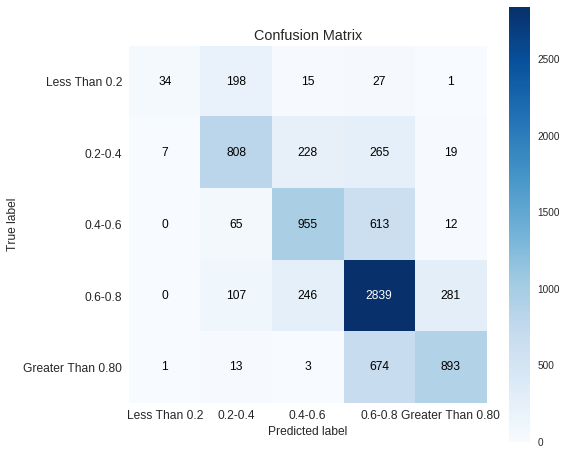

In [0]:
#!pip install scikit-plot
from sklearn.metrics import accuracy_score
import scikitplot.plotters as skplt
skplt.plot_confusion_matrix(y_train_class, clf.predict(X_train_s),figsize = (8,8), labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])
print('\n Training Accuracy: {}'.format(accuracy_score(y_train_class, clf.predict(X_train_s))))



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



 Validation Accuracy: 0.6533461723639865


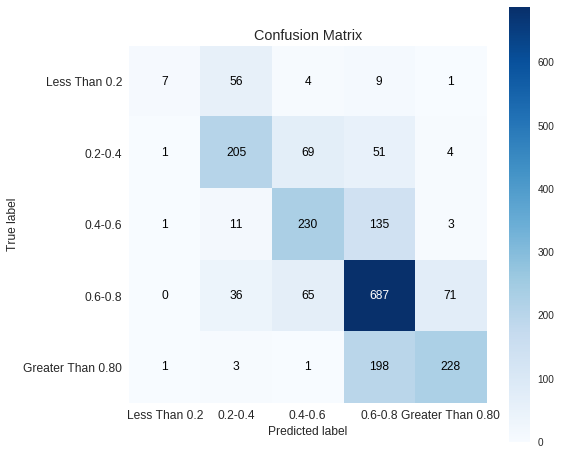

In [0]:
skplt.plot_confusion_matrix(y_val_class, clf.predict(X_val_s),figsize = (8,8), labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])
print('\n Validation Accuracy: {}'.format(accuracy_score(y_val_class, clf.predict(X_val_s))))

### Model 2: Random Forest + Grid Search

#### Binary Classification of Top Quintile Essays: With GridSearch

In [0]:
y_train_top_quintile = pd.cut(y_train, [-1.1, 0.8, 1.1], labels=False, retbins=False, right=False)
y_train_top_quintile = pd.to_numeric(y_train_top_quintile.round(0)).astype(int)

y_val_top_quintile = pd.cut(y_val, [-1.1, 0.8, 1.1], labels=False, retbins=False, right=False)
y_val_top_quintile = pd.to_numeric(y_val_top_quintile.round(0)).astype(int)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth':[6, 8],
              'min_samples_split':[4,6,8],
              'random_state':[0],
              'n_estimators': [500, 1000],
              'max_features': [3, 6]
}
  
rf_obj=RandomForestClassifier()
rf_Grid = GridSearchCV(rf_obj, param_grid, cv = 5,
                       scoring = 'roc_auc',refit = True, n_jobs=-1, 
                       verbose = 5)

rf_Grid.fit(X_train, y_train_top_quintile.values.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0 
[CV] max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0, score=0.8977533047919484, total=   5.8s
[CV] max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0, score=0.922940607631065, total=   5.9s
[CV] max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0, score=0.8900006572029442, total=   6.0s
[CV] max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=4, n_estimators=500, random_state=0, score=0.901987

[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min


[CV]  max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0, score=0.8986194043863602, total=  11.8s
[CV] max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0, score=0.922579146011717, total=  11.9s
[CV] max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0, score=0.8897659418657053, total=  11.8s
[CV] max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=6, n_estimators=1000, random_state=0, score=0.9025133318311551, total=  11.8s
[CV] max_depth=6, max_features=3, min_samples_split=8, n_estimators=500, random_state=0 
[CV]  max_depth=6, max_features=3, min_samples_split=8, n_estimators=500, random_state=0, score=0.898281414300736, tot

KeyboardInterrupt: ignored

In [0]:
rf_Grid.best_params_

In [0]:
rf_Grid.best_estimator_

In [0]:
best_probs_train_rf = rf_Grid.best_estimator_.predict_proba(X_train)
best_pred_train_rf = rf_Grid.best_estimator_.predict(X_train)

best_probs_val_rf = rf_Grid.best_estimator_.predict_proba(X_val)
best_pred_val_rf = rf_Grid.best_estimator_.predict(X_val)

In [0]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_val_top_quintile, best_pred_val_rf)

In [0]:
from sklearn.metrics import classification_report 
target_names = ['0', '1']
print(classification_report(y_val_top_quintile, best_pred_val_rf, 
                            target_names=target_names))

In [0]:
from sklearn.metrics import roc_auc_score
# limit to probability for class = 1
best_probs_val_rf = rf_Grid.best_estimator_.predict_proba(X_val)[:,1]
best_pred_val_rf = rf_Grid.best_estimator_.predict(X_val)

# calculate roc_auc_score
print("ROC AUC Score: ", roc_auc_score(y_val_top_quintile, best_probs_val_rf).round(3))

In [0]:
from sklearn.metrics import log_loss, accuracy_score
print("Training Accuracy of Random Forest for Top Quintile: ", accuracy_score(y_train_top_quintile, best_pred_train_rf).round(3))
print("Validation Accuracy of Random Forest for Top Quintile: ", accuracy_score(y_val_top_quintile, best_pred_val_rf).round(3))

#### Multi-class Classification with Random Forest
Using Best Estimators from Grid Search

In [0]:
#Creating the dependent variable class

y_train_class_factored = pd.cut(y_train, [-0.10, 0.2, 0.4, 0.6, 0.8, 1.1], labels=False, retbins=False, right=False) + 1
y_train_class_factored = pd.to_numeric(y_train_class_factored.round(0)).astype(int)

#Creating the dependent variable class

y_val_class_factored = pd.cut(y_val, [-0.10, 0.2, 0.4, 0.6, 0.8, 1.1], labels=False, retbins=False, right=False) + 1
y_val_class_factored = pd.to_numeric(y_val_class_factored.round(0)).astype(int)

In [0]:
from sklearn.ensemble import RandomForestClassifier
            
rf_obj_multi = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 42,
                               max_depth = 8, max_features = 6, min_samples_split=8, n_jobs=1)

rf_obj_multi.fit(X_train, y_train_class_factored)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
best_probs_train_rf_multi = rf_obj_multi.predict_proba(X_train)
best_pred_train_rf_multi = rf_obj_multi.predict(X_train)

best_probs_val_rf_multi = rf_obj_multi.predict_proba(X_val)
best_pred_val_rf_multi = rf_obj_multi.predict(X_val)

In [0]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_val_class_factored, best_pred_val_rf_multi)

array([[  7,  59,   1,   9,   1],
       [  4, 214,  62,  46,   4],
       [  0,  15, 242, 122,   1],
       [  0,  35,  65, 684,  75],
       [  1,   3,   1, 166, 260]])

In [0]:
from sklearn.metrics import classification_report 
print(classification_report(y_train_class_factored, best_pred_train_rf_multi, 
                            target_names = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"]))

print(classification_report(y_val_class_factored, best_pred_val_rf_multi,
                           target_names = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"]))

                   precision    recall  f1-score   support

    Less Than 0.2       0.91      0.26      0.41       275
          0.2-0.4       0.73      0.68      0.70      1327
          0.4-0.6       0.74      0.68      0.71      1645
          0.6-0.8       0.70      0.84      0.76      3473
Greater Than 0.80       0.77      0.65      0.70      1584

      avg / total       0.73      0.73      0.72      8304

                   precision    recall  f1-score   support

    Less Than 0.2       0.58      0.09      0.16        77
          0.2-0.4       0.66      0.65      0.65       330
          0.4-0.6       0.65      0.64      0.64       380
          0.6-0.8       0.67      0.80      0.73       859
Greater Than 0.80       0.76      0.60      0.67       431

      avg / total       0.68      0.68      0.67      2077



In [0]:
import numpy as np
import matplotlib.pyplot as plt
## start by pulling out the total features
rf_importances_multi = rf_obj_multi.feature_importances_

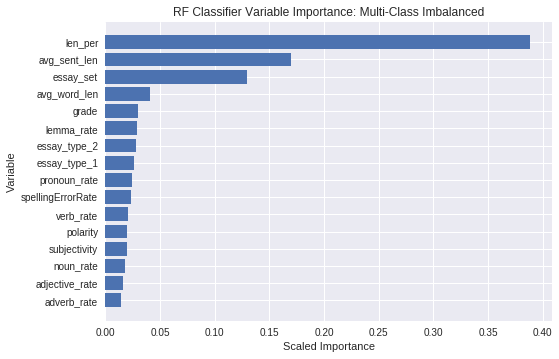

In [0]:
sorted_indices = np.argsort(rf_importances_multi) ####create range of 0-29
y_pos = range(len(rf_importances_multi))
# plotting
plt.barh(y_pos, rf_importances_multi[sorted_indices], align='center') 
plt.yticks(y_pos,X_train.columns[sorted_indices])
plt.title("RF Classifier Variable Importance: Multi-Class Imbalanced") # title 
plt.xlabel("Scaled Importance") #x axis label 
plt.ylabel("Variable") # y axis label
plt.show()

In [0]:
from sklearn.metrics import log_loss, accuracy_score
print("Training Accuracy of Random Forest - MultiClass Imbalanced: ", accuracy_score(y_train_class_factored, best_pred_train_rf_multi).round(3))
print("Validation Accuracy of Random Forest  - MultiClass Imbalanced: ", accuracy_score(y_val_class_factored, best_pred_val_rf_multi).round(3))

Training Accuracy of Random Forest - MultiClass Imbalanced:  0.726
Validation Accuracy of Random Forest  - MultiClass Imbalanced:  0.677


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)



 Training Accuracy: 0.7260356454720617

 Validation Accuracy: 0.6774193548387096


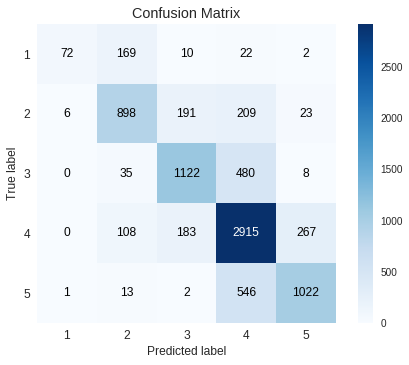

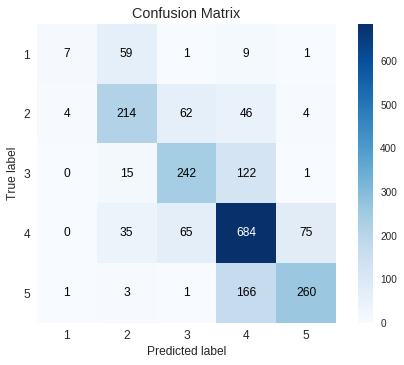

In [0]:
!pip install scikit-plot
import scikitplot.plotters as skplt

skplt.plot_confusion_matrix(y_train_class_factored, best_pred_train_rf_multi)
print('\n Training Accuracy: {}'.format(accuracy_score(y_train_class_factored, best_pred_train_rf_multi)))

skplt.plot_confusion_matrix(y_val_class_factored, best_pred_val_rf_multi)
print('\n Validation Accuracy: {}'.format(accuracy_score(y_val_class_factored, best_pred_val_rf_multi)))

#### Multi-class Classification with Random Forest + Balancing

In [0]:
from sklearn.ensemble import RandomForestClassifier
            
rf_obj_multi_bal = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', 
                                      random_state = 42, max_depth = 8, max_features = 6, 
                                      min_samples_split=8, n_jobs=1, class_weight = "balanced")

rf_obj_multi_bal.fit(X_train, y_train_class_factored)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=8, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [0]:
best_probs_train_rf_multi_bal = rf_obj_multi_bal.predict_proba(X_train)
best_pred_train_rf_multi_bal = rf_obj_multi_bal.predict(X_train)

best_probs_val_rf_multi_bal = rf_obj_multi_bal.predict_proba(X_val)
best_pred_val_rf_multi_bal = rf_obj_multi_bal.predict(X_val)

In [0]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_val_class_factored, best_pred_val_rf_multi_bal)

array([[ 42,  28,   1,   4,   2],
       [ 64, 185,  60,  13,   8],
       [  2,  15, 302,  55,   6],
       [  2,  77, 151, 439, 190],
       [  2,   4,   7,  73, 345]])

In [0]:
from sklearn.metrics import classification_report 
print(classification_report(y_train_class_factored, best_pred_train_rf_multi_bal, 
                            target_names = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"]))

print(classification_report(y_val_class_factored, best_pred_val_rf_multi_bal,
                           target_names = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"]))

                   precision    recall  f1-score   support

    Less Than 0.2       0.57      0.96      0.71       275
          0.2-0.4       0.69      0.64      0.67      1327
          0.4-0.6       0.65      0.83      0.73      1645
          0.6-0.8       0.82      0.56      0.67      3473
Greater Than 0.80       0.64      0.87      0.74      1584

      avg / total       0.72      0.70      0.69      8304

                   precision    recall  f1-score   support

    Less Than 0.2       0.38      0.55      0.44        77
          0.2-0.4       0.60      0.56      0.58       330
          0.4-0.6       0.58      0.79      0.67       380
          0.6-0.8       0.75      0.51      0.61       859
Greater Than 0.80       0.63      0.80      0.70       431

      avg / total       0.66      0.63      0.63      2077



In [0]:
import numpy as np
import matplotlib.pyplot as plt
## start by pulling out the total features
rf_importances_multi_bal = rf_obj_multi_bal.feature_importances_

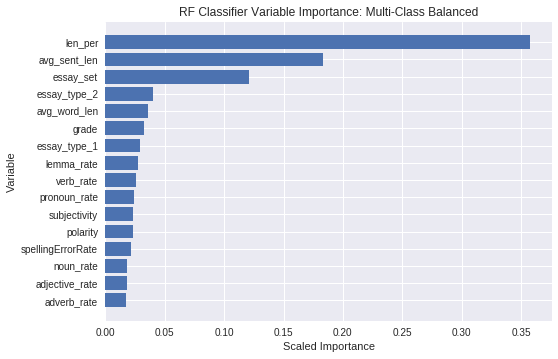

In [0]:
sorted_indices = np.argsort(rf_importances_multi_bal) ####create range of 0-29
y_pos = range(len(rf_importances_multi_bal))
# plotting
plt.barh(y_pos, rf_importances_multi_bal[sorted_indices], align='center') 
plt.yticks(y_pos,X_train.columns[sorted_indices])
plt.title("RF Classifier Variable Importance: Multi-Class Balanced") # title 
plt.xlabel("Scaled Importance") #x axis label 
plt.ylabel("Variable") # y axis label
plt.show()

In [0]:
from sklearn.metrics import log_loss, accuracy_score
print("Training Accuracy of Random Forest - MultiClass Balanced: ", accuracy_score(y_train_class_factored, best_pred_train_rf_multi_bal).round(3))
print("Validation Accuracy of Random Forest - MultiClass Balanced: ", accuracy_score(y_val_class_factored, best_pred_val_rf_multi_bal).round(3))

Training Accuracy of Random Forest - MultiClass Balanced:  0.698
Validation Accuracy of Random Forest - MultiClass Balanced:  0.632



 Training Accuracy: 0.6983381502890174


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)



 Validation Accuracy: 0.6321617717862301


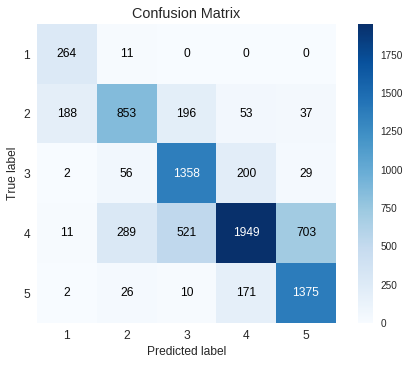

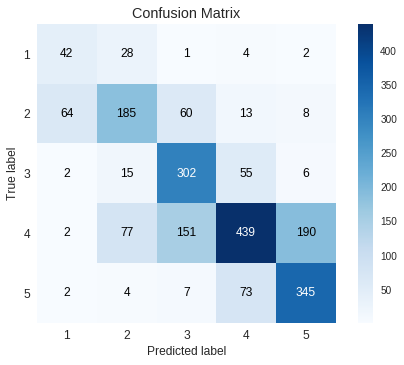

In [0]:
import scikitplot.plotters as skplt

skplt.plot_confusion_matrix(y_train_class_factored, best_pred_train_rf_multi_bal)
print('\n Training Accuracy: {}'.format(accuracy_score(y_train_class_factored, best_pred_train_rf_multi_bal)))

skplt.plot_confusion_matrix(y_val_class_factored, best_pred_val_rf_multi_bal)
print('\n Validation Accuracy: {}'.format(accuracy_score(y_val_class_factored, best_pred_val_rf_multi_bal)))

### Model 3: Ensemble Model - TF-IDF + Multi-class Classification

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


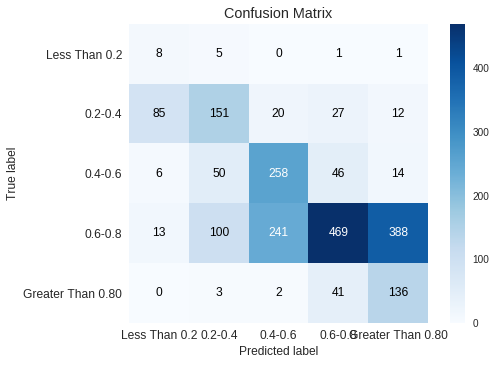

In [0]:
#["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])
RF_best_val = pd.Series(best_pred_val_rf_multi_bal)
RF_best_val[best_pred_val_rf_multi_bal==1]="Less Than 0.2"
RF_best_val[best_pred_val_rf_multi_bal==2]="0.2-0.4"
RF_best_val[best_pred_val_rf_multi_bal==3]="0.4-0.6"
RF_best_val[best_pred_val_rf_multi_bal==4]="0.6-0.8"
RF_best_val[best_pred_val_rf_multi_bal==5]="Greater Than 0.80"

base_ens = pd.Series(base_model_pred_val, dtype="category")
RF_best_val = pd.Series(RF_best_val, dtype="category")
skplt.plot_confusion_matrix(base_ens, RF_best_val, labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])


In [0]:
ens_pred = pd.Series([])
for i in range(0, len(base_ens)):
  if base_ens[i]  == RF_best_val[i]:
    ens_pred[i] = base_ens[i]
  elif ((base_ens[i] is "Less Than 0.2") & (RF_best_val[i] == "0.4-0.6")) or ((RF_best_val[i] is "Less Than 0.2") & (base_ens[i] == "0.4-0.6")):
    ens_pred[i] = "0.2-0.4"
  elif ((base_ens[i] == "0.2-0.4") & (RF_best_val[i] == "0.6-0.8")) or ((RF_best_val[i] == "0.2-0.4") & (base_ens[i] == "0.6-0.8")):
    ens_pred[i] = "0.4-0.6"
  elif ((base_ens[i] == "0.4-0.6") & (RF_best_val[i] is "Greater Than 0.80")) or ((RF_best_val[i] == "0.4-0.6") & (base_ens[i] is "Greater Than 0.80")):
    ens_pred[i] = "0.6-0.8"
  elif ((base_ens[i] == "Less Than 0.2") & (RF_best_val[i] is "Greater Than 0.80")) or ((RF_best_val[i] == "Less Than 0.2") & (base_ens[i] is "Greater Than 0.80")):
    ens_pred[i] = "0.4-0.6"
  else:
    ens_pred[i] = RF_best_val[i]

Accuracy: 0.6061627347135291


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


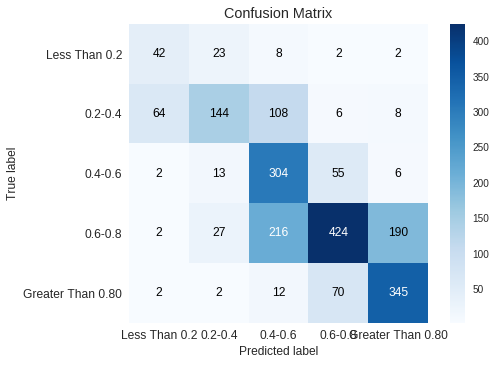

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_val_class, ens_pred)))
skplt.plot_confusion_matrix(y_val_class, ens_pred, labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

# Model Selection in Test: Random Forest without Balancing

In [0]:
# Load in pickle object from above
import pickle
X_test = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/X_test', "rb" ))
y_test = pickle.load( open('/content/drive/Team Drives/ML Project Drive/Final Analysis Components/Step 2 - Cross Validation Data/y_test', "rb" ))

In [0]:
#Creating the dependent variable class

y_test_class_factored = pd.cut(y_test, [-0.10, 0.2, 0.4, 0.6, 0.8, 1.1], labels=False, retbins=False, right=False) + 1
y_test_class_factored = pd.to_numeric(y_test_class_factored.round(0)).astype(int)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf_obj_multi.fit(X_test, y_test_class_factored)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
best_probs_test_rf_multi = rf_obj_multi.predict_proba(X_test)
best_pred_test_rf_multi = rf_obj_multi.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_test_class_factored, best_pred_test_rf_multi)

array([[ 43,  39,   1,   4,   1],
       [  0, 283,  39,  49,   2],
       [  0,   1, 382, 117,   6],
       [  0,  27,  35, 952,  66],
       [  0,   1,   0, 177, 371]])

In [0]:
from sklearn.metrics import classification_report 
print(classification_report(y_test_class_factored, best_pred_test_rf_multi, 
                            target_names = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"]))

                   precision    recall  f1-score   support

    Less Than 0.2       1.00      0.49      0.66        88
          0.2-0.4       0.81      0.76      0.78       373
          0.4-0.6       0.84      0.75      0.79       506
          0.6-0.8       0.73      0.88      0.80      1080
Greater Than 0.80       0.83      0.68      0.75       549

      avg / total       0.79      0.78      0.78      2596



In [0]:
import numpy as np
import matplotlib.pyplot as plt
## start by pulling out the total features
rf_importances_multi_test = rf_obj_multi.feature_importances_

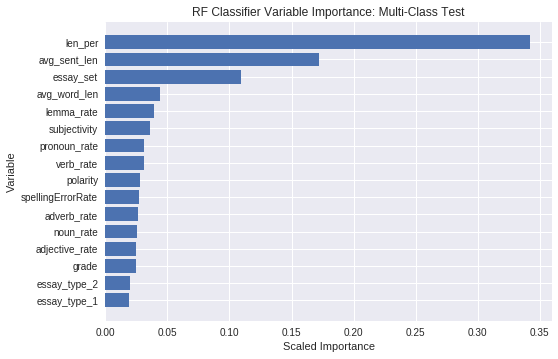

In [0]:
sorted_indices = np.argsort(rf_importances_multi_test) ####create range of 0-29
y_pos = range(len(rf_importances_multi_test))
# plotting
plt.barh(y_pos, rf_importances_multi_test[sorted_indices], align='center') 
plt.yticks(y_pos,X_test.columns[sorted_indices])
plt.title("RF Classifier Variable Importance: Multi-Class Test") # title 
plt.xlabel("Scaled Importance") #x axis label 
plt.ylabel("Variable") # y axis label
plt.show()

In [0]:
from sklearn.metrics import log_loss, accuracy_score
print("Test Accuracy of Random Forest - MultiClass Imbalanced: ", accuracy_score(y_test_class_factored, best_pred_test_rf_multi).round(3))

Test Accuracy of Random Forest - MultiClass Imbalanced:  0.782


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)



 Test Accuracy: 0.7823574730354391


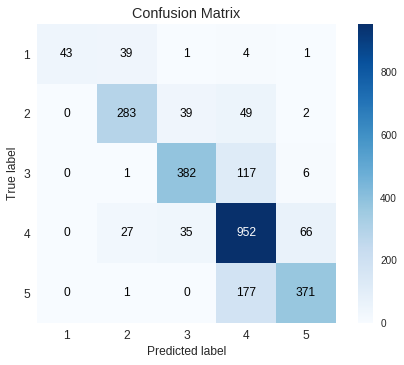

In [0]:
#!pip install scikit-plot
import scikitplot.plotters as skplt

skplt.plot_confusion_matrix(y_test_class_factored, best_pred_test_rf_multi)
print('\n Test Accuracy: {}'.format(accuracy_score(y_test_class_factored, best_pred_test_rf_multi)))

In [0]:
!jupyter nbconvert --to html '/content/drive/Team Drives/ML Project Drive/Colab Notebooks/Copy of FinalProject.ipynb';

[NbConvertApp] Converting notebook /content/drive/Team Drives/ML Project Drive/Colab Notebooks/Copy of FinalProject.ipynb to html
[NbConvertApp] Writing 2096207 bytes to /content/drive/Team Drives/ML Project Drive/Colab Notebooks/Copy of FinalProject.html


## Code Appendix

Some of the additional code snippets we used throughout the project

In [0]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA()
X_train_pca = pca.fit_transform(X_train_s)
X_val_pca = pca.fit_transform(X_val_s)

log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_train_class)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### PCA + Logistic Regression

In [0]:
#Error Evaluation
print('Train - Error Eval')
print(log_reg_pca.score(X_train_pca, y_train_class).round(3))

print('Test - Error Eval')
print(log_reg_pca.score(X_val_pca, y_val_class).round(3))

Train - Error Eval
0.611
Test - Error Eval
0.582


In [0]:
#Confusion Matrix
y_train_pca = log_reg_pca.predict(X_train_pca)
y_test_pca = log_reg_pca.predict(X_val_pca)

from sklearn.metrics import confusion_matrix

print('Train - Confusion Matrix')
print(confusion_matrix(y_train_class, y_train_pca))

print('Test - Confusion Matrix')
print(confusion_matrix(y_val_class, y_test_pca))

Train - Confusion Matrix
[[ 827  214  261   25    0]
 [ 134  692  806   13    0]
 [ 184  266 2744  279    0]
 [  17   10  749  808    0]
 [ 239    8   28    0    0]]
Test - Confusion Matrix
[[208  55  64   3   0]
 [ 28 151 197   4   0]
 [ 69  65 645  80   0]
 [  5   7 215 204   0]
 [ 61   2  13   1   0]]


In [0]:
#Classification Report
from sklearn.metrics import classification_report

print('Train - Classification Report')
print(classification_report(y_train_class, y_train_pca))

print('Test - Classification Report')
print(classification_report(y_val_class, y_test_pca))

Train - Classification Report
                   precision    recall  f1-score   support

          0.2-0.4       0.59      0.62      0.61      1327
          0.4-0.6       0.58      0.42      0.49      1645
          0.6-0.8       0.60      0.79      0.68      3473
Greater Than 0.80       0.72      0.51      0.60      1584
    Less Than 0.2       0.00      0.00      0.00       275

      avg / total       0.60      0.61      0.59      8304

Test - Classification Report
                   precision    recall  f1-score   support

          0.2-0.4       0.56      0.63      0.59       330
          0.4-0.6       0.54      0.40      0.46       380
          0.6-0.8       0.57      0.75      0.65       859
Greater Than 0.80       0.70      0.47      0.56       431
    Less Than 0.2       0.00      0.00      0.00        77

      avg / total       0.57      0.58      0.56      2077



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [0]:
from sklearn.metrics import log_loss, accuracy_score
print("Training Accuracy of Logistic + PCA: ", accuracy_score(y_train_class, y_train_pca).round(3))
print("Validation Accuracy of Logistic + PCA: ", accuracy_score(y_val_class, y_test_pca).round(3))

Training Accuracy of Logistic + PCA:  0.611
Validation Accuracy of Logistic + PCA:  0.582


In [0]:
# Code to save data to pickle object
#import pickle
#with open('/content/drive/Team Drives/ML Project Drive/___', 'wb') as scores_norm_file:
#  pickle.dump(___, scores_norm_file)

### Model 1: SVC SVD with TF-IDF

In [0]:
from sklearn.svm import SVC
model_SVC = SVC(kernel='linear', probability=True).fit(tfidf,y_train_class)
SVC_pred = model_SVC.predict(tfidf)
SVC_pred_val = model_SVC.predict(tfidf_val)

Accuracy: 0.7927504816955684


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


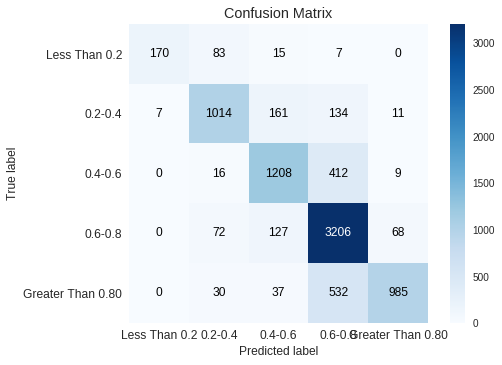

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_train_class, SVC_pred)))

skplt.plot_confusion_matrix(y_train_class, SVC_pred,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

Accuracy: 0.5642753972075109


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


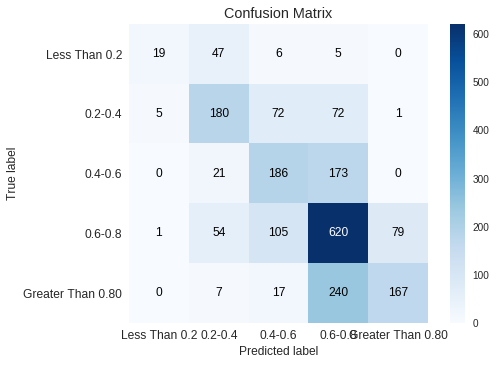

In [0]:
print('Accuracy: {}'.format(accuracy_score(y_val_class, SVC_pred_val)))

skplt.plot_confusion_matrix(y_val_class, SVC_pred_val,labels = ["Less Than 0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "Greater Than 0.80"])

In [0]:
##Code to import data from pickle object
#import pickle
#transformed_base_feat = pickle.load( open( '/content/drive/Team Drives/ML Project Drive/transformed_base_feat.obj', "rb" )

In [0]:
from sklearn import linear_model

lm_single = linear_model.LinearRegression()

singleFactorR2s = pd.DataFrame(index=X_train.columns[1:], columns=['Train R2', 'Validate R2'])

for i in range(1, len(X_train.columns)):
  single_factor_model = lm_single.fit(X_train.iloc[:,i].values.reshape(-1,1), y_train)
  singleFactorR2s.at[X_train.columns[i], 'Train R2'] = single_factor_model.score(X_train.iloc[:,i].values.reshape(-1,1),y_train).round(2)
  singleFactorR2s.at[X_train.columns[i], 'Validate R2'] = single_factor_model.score(X_val.iloc[:,i].values.reshape(-1,1),y_val).round(2)
  
singleFactorR2s

,Train R2,Validate R2
polarity,0,-0
subjectivity,0.01,0.01
grade,0,-0
essay_type_1,0.01,0.01
essay_type_2,0.01,0.01
len_per,0.48,0.51
avg_sent_len,0.15,0.14
avg_word_len,0.06,0.07
spellingErrorRate,0.03,0.02
noun_rate,0.02,0.02


In [0]:
lm = linear_model.LinearRegression()
base_model = lm.fit(X_train.drop(columns='essay_set'),y_train)

In [0]:
print('Base Model Train R squared:')
print(base_model.score(X_train.drop(columns='essay_set'),y_train))

Base Model Train R squared:
0.5170997369763175


In [0]:
print('Base Model Validation R squared:')
print(base_model.score(X_val.drop(columns='essay_set'),y_val))

Base Model Validation R squared:
0.5454201933722795


In [0]:
train_pred = base_model.predict(X_train.drop(columns='essay_set'))

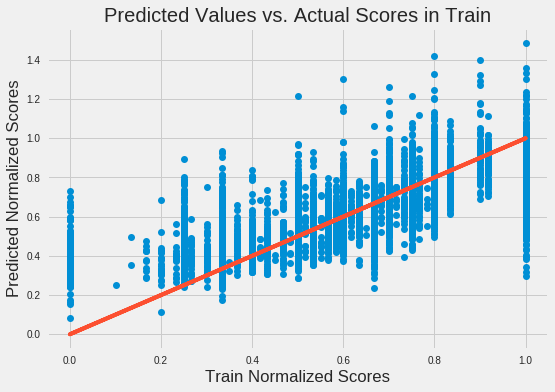

In [0]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

# Generated linear fit
#slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
#line = slope*xi+intercept

plt.plot(y_train,train_pred,'o', y_train, y_train)
pylab.title('Predicted Values vs. Actual Scores in Train')
plt.xlabel('Train Normalized Scores')
plt.ylabel('Predicted Normalized Scores')
plt.show()

In [0]:
# Seperating train data by essay_set 1 
X_train_1 = X_train.loc[X_train['essay_set']==1]
y_train_1 = y_train[X_train['essay_set']==1]
X_train_2 = X_train.loc[X_train['essay_set']==2]
y_train_2 = y_train[X_train['essay_set']==2]
X_train_3 = X_train.loc[X_train['essay_set']==3]
y_train_3 = y_train[X_train['essay_set']==3]
X_train_4 = X_train.loc[X_train['essay_set']==4]
y_train_4 = y_train[X_train['essay_set']==4]
X_train_5 = X_train.loc[X_train['essay_set']==5]
y_train_5 = y_train[X_train['essay_set']==5]
X_train_6 = X_train.loc[X_train['essay_set']==6]
y_train_6 = y_train[X_train['essay_set']==6]
X_train_7 = X_train.loc[X_train['essay_set']==7]
y_train_7 = y_train[X_train['essay_set']==7]
X_train_8 = X_train.loc[X_train['essay_set']==8]
y_train_8 = y_train[X_train['essay_set']==8]

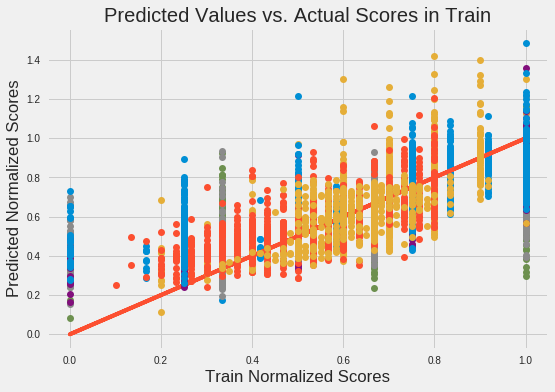

In [0]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

# Generated linear fit
#slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
#line = slope*xi+intercept

plt.plot(y_train_1,base_model.predict(X_train_1.drop(columns='essay_set')),'o',
         y_train, y_train,
         y_train_2,base_model.predict(X_train_2.drop(columns='essay_set')),'o',
         y_train_3,base_model.predict(X_train_3.drop(columns='essay_set')),'o',
         y_train_4,base_model.predict(X_train_4.drop(columns='essay_set')),'o',
         y_train_5,base_model.predict(X_train_5.drop(columns='essay_set')),'o',
         y_train_6,base_model.predict(X_train_6.drop(columns='essay_set')),'o',
         y_train_7,base_model.predict(X_train_7.drop(columns='essay_set')),'o',
         y_train_8,base_model.predict(X_train_8.drop(columns='essay_set')),'o')
pylab.title('Predicted Values vs. Actual Scores in Train')
plt.xlabel('Train Normalized Scores')
plt.ylabel('Predicted Normalized Scores')
plt.show()

In [0]:
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score
print('Base Model Train R squared By Essay Set')
print('Essay Set 1:')
print(r2_score(y_train_1,base_model.predict(X_train_1.drop(columns='essay_set'))))

print('Essay Set 2:')
print(r2_score(y_train_2,base_model.predict(X_train_2.drop(columns='essay_set'))))

print('Essay Set 3:')
print(r2_score(y_train_3,base_model.predict(X_train_3.drop(columns='essay_set'))))

print('Essay Set 4:')
print(r2_score(y_train_4,base_model.predict(X_train_4.drop(columns='essay_set'))))

print('Essay Set 5:')
print(r2_score(y_train_5,base_model.predict(X_train_5.drop(columns='essay_set'))))

print('Essay Set 6:')
print(r2_score(y_train_6,base_model.predict(X_train_6.drop(columns='essay_set'))))

print('Essay Set 7:')
print(r2_score(y_train_7,base_model.predict(X_train_7.drop(columns='essay_set'))))

print('Essay Set 8:')
print(r2_score(y_train_8,base_model.predict(X_train_8.drop(columns='essay_set'))))

Base Model Train R squared By Essay Set
Essay Set 1:
0.6340883083205815
Essay Set 2:
0.11212285125446753
Essay Set 3:
0.4303584750769326
Essay Set 4:
0.45055150531684685
Essay Set 5:
0.6368336564651198
Essay Set 6:
0.4675524297527286
Essay Set 7:
0.3610734584560785
Essay Set 8:
-0.15687374516231256


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



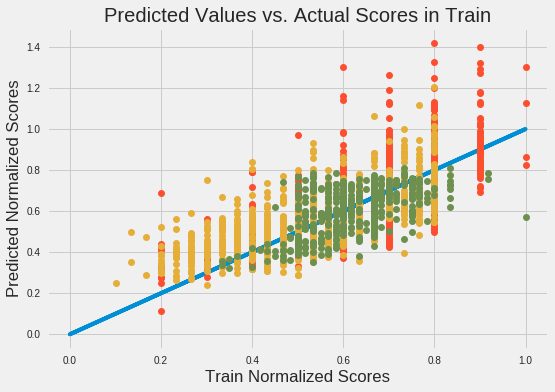

In [0]:
# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

# Generated linear fit
#slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
#line = slope*xi+intercept

plt.plot(y_train, y_train,
         y_train_2,base_model.predict(X_train_2.drop(columns='essay_set')),'o',
         y_train_7,base_model.predict(X_train_7.drop(columns='essay_set')),'o',
         y_train_8,base_model.predict(X_train_8.drop(columns='essay_set')),'o')
pylab.title('Predicted Values vs. Actual Scores in Train')
plt.xlabel('Train Normalized Scores')
plt.ylabel('Predicted Normalized Scores')
plt.show()